### Description:

Cohort was first processed via the demographic notebook, Tiffany processed the labels,
returned for use from here on.

* Clean variables from flowsheet, finalized with vital signs and GCS scores only
* Keep SBP/DBP (BP num_value1 and num_value2), RR, Heart Rate, SpO2, Temp (2 units, num_value1 and num_value2), and GCS (check details). The rest has NA info
* GCS is ultimately not used due to inaccuracy and too many missing values.

Inputs: 
- `flowsheet.csv` (from SQL)
- `cohort_demoHW.csv` -- cohort which has demographics, ESI, and imputed HW processed


Output files: 

* **vitals_clean.csv** --> cleaned vs for joining later
* **vs1st_complete** -- for ESI imputation, cohort with at least a complete set of first VS
* **vitalsum_wide** -- summary stats of vital signs


### Importing R libraries

In [1]:
library(bigrquery)  # to query STARR-OMOP (stored in BigQuery) using SQL
library(tidyverse)
library(lubridate)

# library(data.table)
# library(Matrix)
# library(caret) # import this before glmnet to avoid rlang version problem
# library(glmnet)
# library(bit64)

# library(slam)
# library(mtools) for one hot coder, not available on Nero or use caret or tidyr
# library(mice)

options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

Warning message:
"package 'bigrquery' was built under R version 4.0.5"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




### Set up and run queries
Do this on Nero GCP as querying from a local computer takes much longer time

In [7]:
# CREDENTIALS depending on LOCATIONS:
# credential <- paste0("/home/", "minh084", "/.config/gcloud/application_default_credentials.json")

# local computer
# credential <- "C:/Users/User/AppData/Roaming/gcloud/application_default_credentials.json"

# Nero onprem
# credential <- "/home/minh084/.config/gcloud/application_default_credentials.json"

# Nero gcp notebook
credential <- "/home/jupyter/.config/gcloud/application_default_credentials.json"

project_id <- "som-nero-phi-jonc101"

Sys.setenv(GOOGLE_APPLICATION_CREDENTIALS = credential)
Sys.setenv(GCLOUD_PROJECT = project_id)
gargle::credentials_app_default()

NULL

In [3]:
library(DBI)
con <- dbConnect(
  bigrquery::bigquery(),
  project = project_id,
  dataset = "shc_core" #, billing = project_id
)
con 
dbListTables(con)

<BigQueryConnection>
  Dataset: som-nero-phi-jonc101.shc_core
  Billing: som-nero-phi-jonc101

[1] "adt"                 "allergy"             "culture_sensitivity"
 [4] "demographic"         "dep_map"             "diagnosis_code"     
 [7] "drg_code"            "encounter"           "family_hx"          
[10] "flowsheet"           "lab_result"          "lda"                
[13] "mapped_meds"         "mar"                 "med_orderset"       
[16] "ndc_code"            "order_med"           "order_proc"         
[19] "order_quest"         "proc_note"           "proc_orderset"      
[22] "procedure_code"      "prov_map"            "social_hx"          
[25] "treatment_team"

### Check other flowsheet variables, mainly vital signs:
   * Combine/collapse similar names into standard names for the below features
   * Look at how common these are, look at the distributions, check extreme values on either sides
   * Investigate some of these to see how far they are off from normal range to be considered errorneous.
   * Note: num_value1 vs. num_value2, see details below
   * Replace erroneous values as "NA".
   
**1. Blood pressure**: 
* DBP: num_value2 --> return NA if SBP > 10*DBP 
* There's no DBP without an SBP
* Return NA for BP if both DBP and SBP are 0
* SBP: return NA if < 30 or 33, same effect

**2. Pulse**: return NA if < 21

**3. Temp**: exist in both num_value1 and num_value2
* num_value2 is not NA only when there's num_value1. if num_value1 is NA then num_value2 is also NA
* For num_value1 <= 60, take it as Celcius degree
* For num_value1 > 60, convert this temp in F to C
* Return NA for num_value1 < 20 --> only 2: 0.1 and 9.4 (lowest 26C)

**4. Respiratory Rate (RR)**: return NA for < 4 or > 60

**5. SpO2**: return NA for < 40%. although there are lots of these, they are difficult to interpret without knowing O2 (LPM), which is not a lot here. missing can be considered as room air.

**6. GCS**: points are different from scores, only use scores
* num_value2 are the normal GCS score, num_value1 can be just points on 0-4 scale

In [2]:
# read inputs
datadir = "../../DataTD"
featuredir = "../../OutputTD/2_features"


cohort <- read.csv(file.path(featuredir, "cohort_demoHW.csv"))
vitals0 <- read.csv(file.path(datadir, "flowsheet.csv")) 

# check for unique CSNs and MRNs
nrow(cohort) #45796
nrow(vitals0) #depending on which cohort_demo used to query flowsheet 218930
colnames(vitals0) #854342

[1] 45796

[1] 854342

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "label"                   "admit_time"             
 [5] "inpatient_data_id_coded" "ESI"                    
 [7] "hosp_admsn_time"         "ed_time_hr"             
 [9] "gender"                  "race"                   
[11] "language"                "recent_height_cm"       
[13] "recent_weight_kg"        "insurance"              
[15] "recent_date"             "age"                    
[17] "template"                "row_disp_name"          
[19] "units"                   "recorded_time_utc"      
[21] "num_value1"              "num_value2"

In [3]:
head(cohort, n=1)
head(vitals0, n=1)

,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,gender,race,insurance,age,English,Height,Weight
,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,0,2019-08-31 12:52:00,40679773,3,Female,White,1,52,1,165,81


,anon_id,pat_enc_csn_id_coded,label,admit_time,inpatient_data_id_coded,ESI,hosp_admsn_time,ed_time_hr,gender,race,language,recent_height_cm,recent_weight_kg,insurance,recent_date,age,template,row_disp_name,units,recorded_time_utc,num_value1,num_value2
,<chr>,<dbl>,<int>,<chr>,<int>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,JC2a2d4cd,131278114484,0,2019-10-02 06:10:00+00:00,42877738,2,2019-10-02 01:07:00+00:00,5.05,Male,White,English,182.88,68.04,,2019-11-12,31,Mobility/Activity,Activity,,2019-10-02 04:27:00+00:00,NA,NA


In [6]:
vitals0 %>% group_by(units) %>% count()
vitals0 %>% group_by(row_disp_name) %>% count() %>% arrange(-n)

units,n
<chr>,<int>
,612900
%,228942
bpm,8
LPM,12492


row_disp_name,n
<chr>,<int>
SpO2,228942
Pulse,145920
Resp,138411
BP,137195
Heart Rate,60926
Temp,52940
Temp (in Celsius),40326
Weight,16413
O2 (LPM),12492


In [6]:
# combine cohort with vitals sign, calculate difftime
vitals0 <- vitals0 %>% 
                select(-c(admit_time, label_max24, template, units)) %>%
                rename(recorded_time = recorded_time_utc)

vitals0 <- left_join(cohort, vitals0) %>% 
            mutate(timediff = as.numeric(difftime(admit_time, recorded_time, units = "mins"))) %>%
            distinct()
#             filter(ymd_hms(recorded_time) < ymd_hms(admit_time)) %>% # no need this one, SQL took care of this

nrow(vitals0) 
summary(vitals0$timediff) # all positive --> recorded time is before admit time

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "inpatient_data_id_coded")



[1] 1183353

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0      76     161     325     299 8408429      55 

In [7]:
head(vitals0, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,row_disp_name,recorded_time,num_value1,num_value2,timediff
,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,,2017-06-24,,0,0,BP,2017-06-24 07:21:00+00:00,124,77,335


In [8]:
# check summary to see num_value1 vs num_value
display_summary_num1and2 <- function(df, var1, var2){
    suppressWarnings(
        df %>% summarise(n=n(), 
                        mean1 = mean({{var1}}, na.rm=T), mean2 = mean({{var2}}, na.rm=T),
                        median1 = median({{var1}}, na.rm=T), median2 = median({{var2}}, na.rm=T),
                        min1 = min({{var1}}, na.rm=T), min2 = min({{var2}}, na.rm=T), 
                        max1 = max({{var1}}, na.rm=T), max2 = max({{var2}}, na.rm=T)) %>%
                arrange(desc(n))
    )
}

In [9]:
# check the original vitals data,
# some variables have no values, temp and gcs scores have 2 different units/scales, BP has SBP and DBP
vitals0 %>% group_by(row_disp_name) %>% display_summary_num1and2(num_value1, num_value2)# %>% arrange(desc(n))

row_disp_name,n,mean1,mean2,median1,median2,min1,min2,max1,max2
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SpO2,218712,96.9954372,NaN,98.0,NA,0.000,Inf,100.00,-Inf
Pulse,216960,88.4981930,NaN,87.0,NA,0.000,Inf,300.00,-Inf
Resp,206284,19.1975658,NaN,18.0,NA,0.000,Inf,189.00,-Inf
BP,203895,129.1003573,75.73771,127.0,75.0,0.000,0.0,419.00,238.0
Temp,80111,98.3419080,98.32463,98.2,98.3,0.100,96.7,110.20,101.6
Temp (in Celsius),61787,36.9651965,NaN,36.8,NA,-17.700,Inf,43.40,-Inf
Heart Rate,59445,90.0253662,NaN,88.0,NA,0.000,Inf,295.00,-Inf
Glasgow Coma Scale Score,44373,14.5969755,NaN,15.0,NA,3.000,Inf,15.00,-Inf
O2 (LPM),33014,NaN,NaN,NA,NA,Inf,Inf,-Inf,-Inf


In [10]:
# rename the variables, combine similar ones
# only 1 name: SpO2 and BP
GCS = c("Glasgow", "GCS Score") # 40654 + 44 = 40698 # not using GCS points, different scale
Pulse = c("Pulse", "Heart Rate") 
RR = c("Resp", "Resp Rate") # not using Respiratory Rate, different scale

# will name BP as SBP and take num_value1 only, DBP will be processed separately
# distinct will reduce many rows, that have values with same recorded time
vitals <- vitals0 %>% rename(features = row_disp_name) %>% 
                mutate(features = ifelse(str_detect(features, paste(GCS, collapse="|")), "GCS",
                                    ifelse(features == "BP", "SBP",
                                    ifelse(features %in% Pulse, "Pulse", 
                                    ifelse(features == "SpO2", "SpO2",
                                    ifelse(str_detect(features, "Temp"), "Temp", 
                                    ifelse(features %in% RR, "RR", as.character(features)))))))) %>% # last ... in ifelse(cond, iftrue, ...)
                distinct()
nrow(vitals)       
unique(vitals$features)
fs_feats <- c("Pulse", "SpO2", "RR", "SBP", "Temp", "GCS")
vitals %>% filter(features %in% fs_feats) %>% group_by(features) %>% display_summary_num1and2(num_value1, num_value2)

[1] 1166786

[1] "SBP"                  "RR"                   "SpO2"                
 [4] "Temp"                 "Pulse"                "Weight"              
 [7] "GCS"                  "Height"               "O2 (LPM)"            
[10] "Activity"             "Mobility"             "Oxygen Saturation"   
[13] "Blood Pressure"       "Respiratory Rate"     "LOC"                 
[16] "Total GCS Points"     "LOC Score"            NA                    
[19] "O2 Flow (L/min)"      "Arterial Systolic BP" "NIBP"

features,n,mean1,mean2,median1,median2,min1,min2,max1,max2
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pulse,260086,88.84113,NaN,87.0,NA,0.0,Inf,300.0,-Inf
SpO2,218712,96.99544,NaN,98.0,NA,0.0,Inf,100.0,-Inf
RR,206286,19.19752,NaN,18.0,NA,0.0,Inf,189.0,-Inf
SBP,203895,129.10036,75.73771,127.0,75.0,0.0,0.0,419.0,238.0
Temp,141651,71.59153,98.32463,97.5,98.3,-17.7,96.7,110.2,101.6
GCS,44418,14.58237,13.42857,15.0,15.0,0.0,4.0,15.0,15.0


### num_value1 vs num_value2:
* Temp: num_value1 (in C when num_value2 is not NA) and num_value2 (F)  vs. Temp(in C) num_value1
* BP --> SBP: num_value1; DBP: num_value2. Do not use Blood Pressure (0-2 scale)
* GCS: Glasgow Coma Scale Score's num_value1 and GCS Score's num_value1. Do not use POINTS, it's different scale 0-4
* SpO2, Pulse & Heart Rate, RR or Resp Rate (Do not use Respiratory Rate --> different scale) : num_value1

### Check Temperatures
* Only check Temp becuase Temp in C only has num_value1 in C where as Temp has both C and F degrees

In [11]:
# when num_value2 is not NA, take num_value1, equivalent, in C --> all look correct
summary(vitals0 %>% filter(row_disp_name == "Temp" & !is.na(num_value2)) %>% select(num_value1, num_value2))

# when num_value2 is NA or num_value1 is not NA, --> need further checking
summary(vitals0 %>% filter(row_disp_name == "Temp" & is.na(num_value2)) %>% select(num_value1, num_value2))
summary(vitals0 %>% filter(row_disp_name == "Temp" & !is.na(num_value1)) %>% select(num_value1, num_value2))

# when num_value1 is less than 3, num_value2 = NA
summary(vitals0 %>% filter(row_disp_name == "Temp" & num_value1 < 3) %>% select(num_value1, num_value2))

# when num_value1 is NA --> num_value2 is also NA
summary(vitals0 %>% filter(row_disp_name == "Temp" & is.na(num_value1)) %>% select(num_value1, num_value2))

   num_value1      num_value2    
 Min.   :35.90   Min.   : 96.70  
 1st Qu.:36.60   1st Qu.: 97.90  
 Median :36.80   Median : 98.30  
 Mean   :36.85   Mean   : 98.32  
 3rd Qu.:37.00   3rd Qu.: 98.60  
 Max.   :38.70   Max.   :101.60  

   num_value1      num_value2   
 Min.   :  0.1   Min.   : NA    
 1st Qu.: 97.9   1st Qu.: NA    
 Median : 98.3   Median : NA    
 Mean   : 98.5   Mean   :NaN    
 3rd Qu.: 98.8   3rd Qu.: NA    
 Max.   :110.2   Max.   : NA    
 NA's   :456     NA's   :79908  

   num_value1       num_value2    
 Min.   :  0.10   Min.   : 96.70  
 1st Qu.: 97.90   1st Qu.: 97.90  
 Median : 98.20   Median : 98.30  
 Mean   : 98.34   Mean   : 98.32  
 3rd Qu.: 98.80   3rd Qu.: 98.60  
 Max.   :110.20   Max.   :101.60  
                  NA's   :79452   

   num_value1    num_value2 
 Min.   :0.1   Min.   : NA  
 1st Qu.:0.1   1st Qu.: NA  
 Median :0.1   Median : NA  
 Mean   :0.1   Mean   :NaN  
 3rd Qu.:0.1   3rd Qu.: NA  
 Max.   :0.1   Max.   : NA  
               NA's   :1    

   num_value1    num_value2 
 Min.   : NA   Min.   : NA  
 1st Qu.: NA   1st Qu.: NA  
 Median : NA   Median : NA  
 Mean   :NaN   Mean   :NaN  
 3rd Qu.: NA   3rd Qu.: NA  
 Max.   : NA   Max.   : NA  
 NA's   :456   NA's   :456  

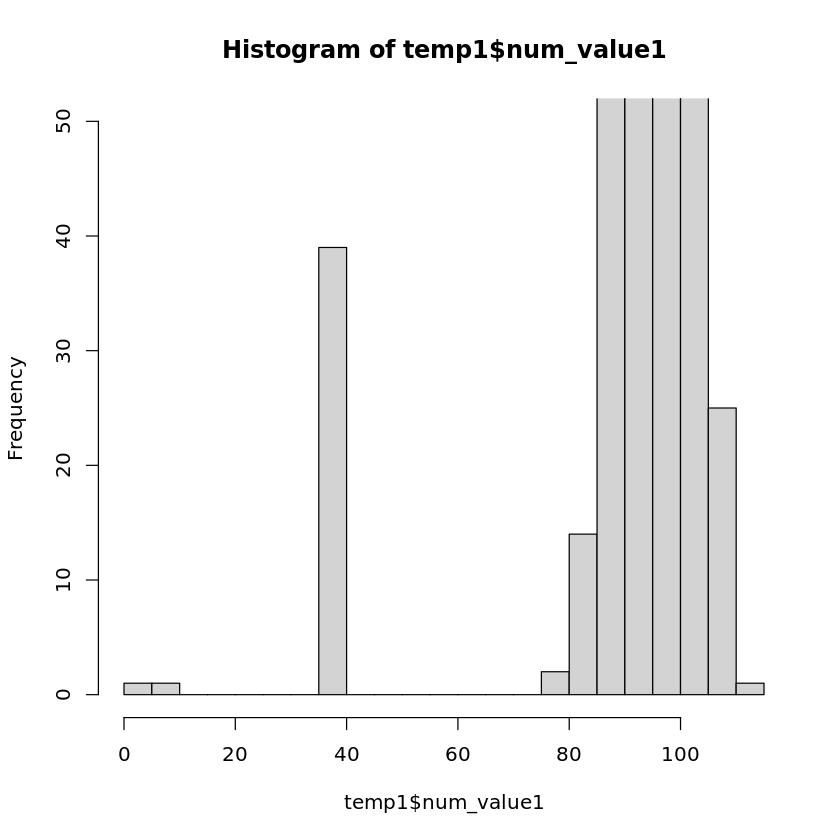

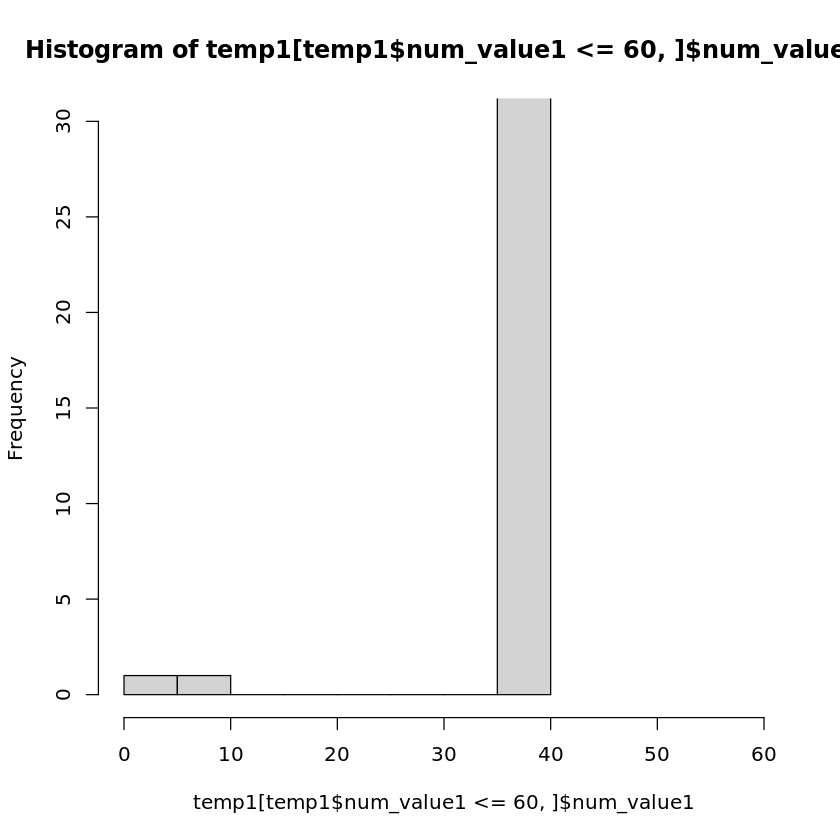

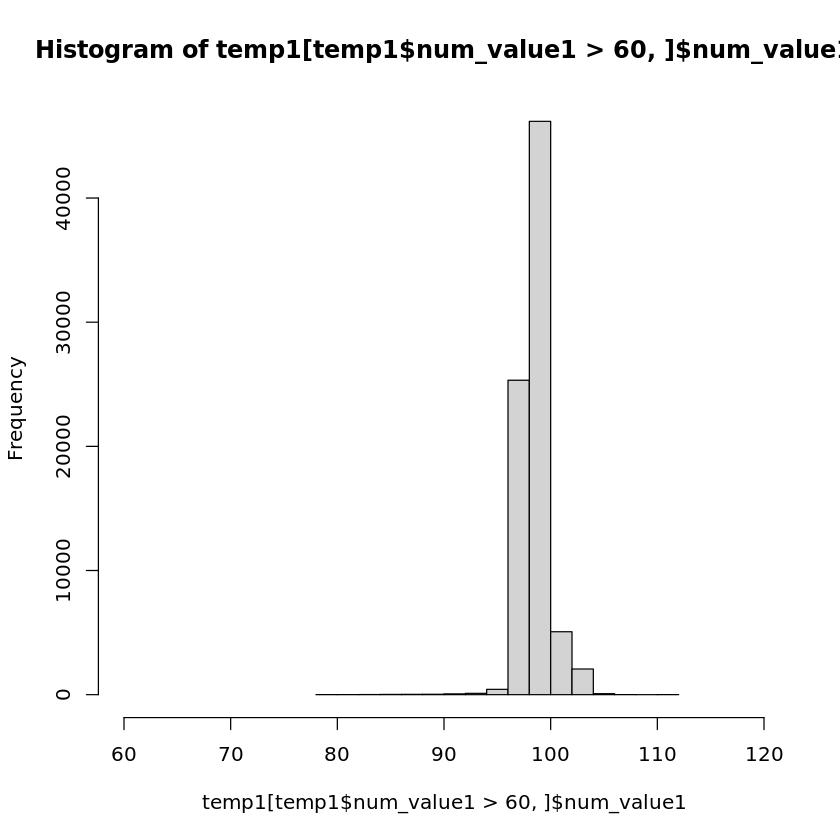

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,row_disp_name,recorded_time,num_value1,num_value2,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
JCd97296,131176042095,18290644,0,2016-02-06 22:31:00+00:00,NA,0,NA,0,0,⋯,,2016-02-06,,0,0,Temp (in Celsius),2016-02-06 20:45:00+00:00,29.8,NA,106
JCd97296,131176042095,18290644,0,2016-02-06 22:31:00+00:00,NA,0,NA,0,0,⋯,,2016-02-06,,0,0,Temp (in Celsius),2016-02-06 20:35:00+00:00,29.7,NA,116
JCe0a094,131267573883,36777900,1,2019-05-25 21:49:00+00:00,1,1,1,1,1,⋯,2019-06-10,2019-05-25,16 days,1,0,Temp (in Celsius),2019-05-25 21:30:00+00:00,29.7,NA,19
JCe88fa0,131224771962,24096907,0,2017-03-12 13:05:00+00:00,0,0,0,1,0,⋯,,2017-03-12,,0,0,Temp (in Celsius),2017-03-12 10:18:00+00:00,29.5,NA,167
JCe37fab,131181402655,19046301,1,2016-02-28 21:08:00+00:00,1,1,1,1,1,⋯,,2016-02-28,,0,0,Temp (in Celsius),2016-02-28 20:27:00+00:00,28.9,NA,41
JCdd9bab,131263773440,34384015,1,2019-03-17 23:19:00+00:00,1,1,1,1,1,⋯,,2019-03-17,,1,0,Temp (in Celsius),2019-03-17 20:25:00+00:00,28.1,NA,174
JC2a08731,131279102282,43446955,1,2019-10-16 13:09:00+00:00,1,1,1,1,1,⋯,,2019-10-16,,1,0,Temp (in Celsius),2019-10-16 12:05:00+00:00,27.8,NA,64
JCde680b,131263588795,34321134,1,2019-01-18 18:47:00+00:00,1,1,1,1,1,⋯,,2019-01-18,,1,0,Temp (in Celsius),2019-01-18 18:20:00+00:00,27.7,NA,27
JCde680b,131263588795,34321134,1,2019-01-18 18:47:00+00:00,1,1,1,1,1,⋯,,2019-01-18,,1,0,Temp (in Celsius),2019-01-18 16:53:00+00:00,26.4,NA,114


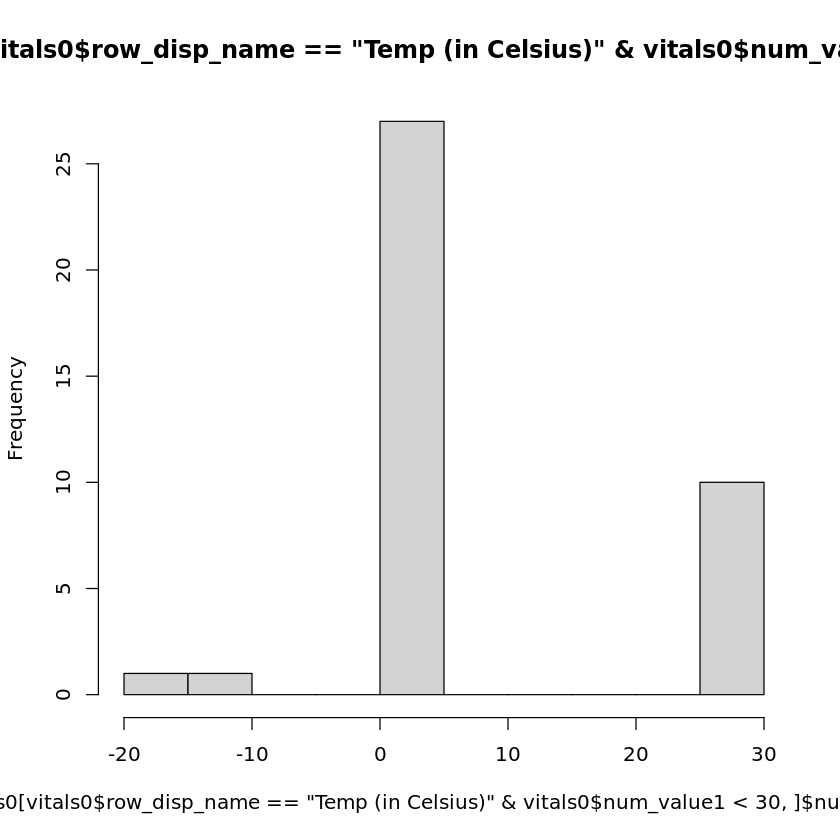

In [12]:
# check when num_value2 is NA:
# for num_value1 <= 60, take it, and for num_value1 > 60, convert to C
# return NA for < 10 (or 20) --> only 2: 0.1 and 9.4,  
temp1 <- vitals0 %>% filter(row_disp_name=="Temp"  & is.na(num_value2)) %>% arrange(num_value1)
hist(temp1$num_value1, ylim=c(0, 50))

hist(temp1[temp1$num_value1<=60, ]$num_value1, xlim=c(0, 60), ylim=c(0,30))
hist(temp1[temp1$num_value1>60, ]$num_value1, xlim=c(60, 120))

# now check the other temp variable, max is 43.6
hist(vitals0[vitals0$row_disp_name=="Temp (in Celsius)" & vitals0$num_value1 < 30, ]$num_value1)
vitals0 %>% filter(row_disp_name =="Temp (in Celsius)" & num_value1 < 30) %>% arrange(desc(num_value1))

### Check GCS scores
* GCS, num_value2 is good, but GCS Score num_value1 is on 0-2 scale --> either repalce num_value1 by num_value2 earlier then only use num_value1 
* if use GCS points --> 0- 4 in num_value1 (points) --> not using this
* or, here, just use num_value1 for all >= 3 and for any <3, use num_value2 (no overlapping). 
* If there's overlapping like GCS points, then we need to process this prior to combining the names as above

In [13]:
gcs <- vitals %>% filter(features == "GCS")
summary(gcs %>% select(num_value1, num_value2)) 

# if num_value1 is na, then no num_value2 --> no num_value2 without num_value1
gcs2 <- gcs %>% filter(is.na(num_value1)) %>% arrange(num_value2)
summary(gcs2$num_value2)

# when num_value1 >= 3, then all NA for num_value2 --> take all num_value1 >= 3
nrow(gcs %>% filter(num_value1 >= 3) %>% drop_na(num_value2))
# for num_value1  < 3, only 7 has num_value2 --> take these
gcs %>% filter(num_value1 < 3 | is.na(num_value1)) %>% drop_na(num_value2)

# if num_value2 is na, there are still num_value1
gcs1 <- gcs %>% filter(is.na(num_value2)) %>% arrange(num_value1)
summary(gcs1$num_value1)

   num_value1      num_value2   
 Min.   : 0.00   Min.   : 4.00  
 1st Qu.:15.00   1st Qu.:15.00  
 Median :15.00   Median :15.00  
 Mean   :14.58   Mean   :13.43  
 3rd Qu.:15.00   3rd Qu.:15.00  
 Max.   :15.00   Max.   :15.00  
 NA's   :135     NA's   :44411  

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
     NA      NA      NA     NaN      NA      NA     135 

[1] 0

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,num_value1,num_value2,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
JCd7818b,131277778367,42661661,0,2019-11-11 20:07:00+00:00,0,0,0,1,0,⋯,2019-11-14,2019-11-11,3 days,1,0,GCS,2019-11-11 18:56:00+00:00,2,4,71
JCe73f0c,131265556238,35444266,0,2019-03-12 21:07:00+00:00,0,0,0,1,0,⋯,,2019-03-12,,1,0,GCS,2019-03-12 19:08:00+00:00,0,15,119
JCde21ba,131271457838,38547323,1,2019-05-30 21:14:00+00:00,1,1,1,1,1,⋯,,2019-05-30,,1,0,GCS,2019-05-30 21:00:00+00:00,0,15,14
JCde568a,131275162851,40953733,1,2019-10-06 21:02:00+00:00,1,1,1,1,1,⋯,2019-10-10,2019-10-06,4 days,0,0,GCS,2019-10-06 19:27:00+00:00,0,15,95
JCdfb088,131269828562,38125104,1,2019-05-24 08:45:00+00:00,1,1,1,1,1,⋯,,2019-05-24,,1,0,GCS,2019-05-24 08:40:00+00:00,0,15,5
JCe559b8,131272738903,39402070,1,2019-07-10 20:30:00+00:00,1,1,1,1,1,⋯,2020-01-25,2019-07-10,199 days,1,0,GCS,2019-07-10 19:00:00+00:00,0,15,90
JC2a0db00,131272730479,39396664,1,2019-07-10 18:19:00+00:00,1,1,1,1,1,⋯,,2019-07-10,,0,0,GCS,2019-07-10 17:45:00+00:00,0,15,34


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   15.00   15.00   14.58   15.00   15.00     135 

In [14]:
# GCS: cannot < 3 --> take all num_value1 >=3 (no num_value2), otherwise, replace num_value1 by num_value2 (only 7 entries)
# keep this one separate as we will row bind later
gcs <- gcs %>% mutate(num_value1 = ifelse(num_value1 >=3, num_value1, num_value2)) %>% 
                    drop_na(num_value1) %>% mutate(features = "GCS") %>% 
                    select(-c(num_value2, timediff)) %>%
                    rename(values = num_value1)
nrow(gcs)
summary(gcs$values)

# looks for errors GCS 4 and 15 at the same time
gcs %>% filter(pat_enc_csn_id_coded %in% c(131187403487) | anon_id =="JCec2887")

# remove total GCS points solved the problem of GCS 4 and 15 at the same time
# here, check if any rows that are the same except for values
gcs %>% group_by_at(vars(-values)) %>% filter(n() > 1) 

[1] 44245

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0    15.0    15.0    14.6    15.0    15.0 

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,critical_to_acute_label,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>
JCdbf9f6,131187403487,19956810,0,2016-06-02 01:46:00+00:00,0,0,0,1,0,⋯,0,0,,2016-06-02,,0,0,GCS,2016-06-01 19:34:00+00:00,15
JCdbf9f6,131187403487,19956810,0,2016-06-02 01:46:00+00:00,0,0,0,1,0,⋯,0,0,,2016-06-02,,0,0,GCS,2016-06-01 19:07:15+00:00,15
JCdbf9f6,131187403487,19956810,0,2016-06-02 01:46:00+00:00,0,0,0,1,0,⋯,0,0,,2016-06-02,,0,0,GCS,2016-06-01 19:45:00+00:00,15
JCdbf9f6,131187403487,19956810,0,2016-06-02 01:46:00+00:00,0,0,0,1,0,⋯,0,0,,2016-06-02,,0,0,GCS,2016-06-01 19:40:00+00:00,15
JCdbf9f6,131187403487,19956810,0,2016-06-02 01:46:00+00:00,0,0,0,1,0,⋯,0,0,,2016-06-02,,0,0,GCS,2016-06-01 19:32:00+00:00,15
JCdbf9f6,131187403487,19956810,0,2016-06-02 01:46:00+00:00,0,0,0,1,0,⋯,0,0,,2016-06-02,,0,0,GCS,2016-06-01 19:33:18+00:00,15
JCdbf9f6,131187403487,19956810,0,2016-06-02 01:46:00+00:00,0,0,0,1,0,⋯,0,0,,2016-06-02,,0,0,GCS,2016-06-01 19:51:00+00:00,15


Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,critical_to_acute_label,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>


### Check DBP and process this separately, to bind rows afterward

In [16]:
# check DBP (num_value2). Note: BP always have 2 values
nrow(vitals %>% filter(features == "SBP" & is.na(num_value1) & !is.na(num_value2)))
nrow(vitals %>% filter(features == "SBP" & is.na(num_value2) & !is.na(num_value1)))

# display some extrem values of DBP
options(repr.matrix.max.rows=150, repr.matrix.max.cols=20)
vitals %>% filter(features == 'SBP' & (num_value2 > 200 | num_value2 < 25)) %>% arrange(num_value2)

[1] 0

[1] 0

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,num_value1,num_value2,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
JCd04de5,131068992117,14201240,0,2015-03-01 06:59:00+00:00,0,0,0,1,0,⋯,2019-01-01,2015-03-01,1402 days,0,0,SBP,2015-03-01 01:18:00+00:00,60,0,341.00000
JCd04de5,131068992117,14201240,0,2015-03-01 06:59:00+00:00,0,0,0,1,0,⋯,2019-01-01,2015-03-01,1402 days,0,0,SBP,2015-03-01 06:30:00+00:00,74,0,29.00000
JCd04de5,131068992117,14201240,0,2015-03-01 06:59:00+00:00,0,0,0,1,0,⋯,2019-01-01,2015-03-01,1402 days,0,0,SBP,2015-03-01 01:42:00+00:00,74,0,317.00000
JCd4aff3,131268077771,37106042,0,2019-05-10 18:10:00+00:00,0,0,0,1,0,⋯,2020-03-14,2019-05-10,309 days,0,0,SBP,2019-05-10 16:30:00+00:00,80,0,100.00000
JCdcddf3,131066249809,14065631,0,2015-01-26 11:44:00+00:00,0,0,0,1,0,⋯,2019-01-01,2015-01-26,1436 days,0,0,SBP,2015-01-26 11:00:00+00:00,80,0,44.00000
JCe9159a,131101395078,16149752,0,2015-07-28 01:38:00+00:00,0,0,0,1,0,⋯,2019-01-01,2015-07-28,1253 days,0,0,SBP,2015-07-27 14:59:00+00:00,90,0,639.00000
JCd3b2e3,131106311493,16305407,1,2015-07-16 09:47:00+00:00,1,1,1,1,1,⋯,,2015-07-16,,0,0,SBP,2015-07-16 04:58:29+00:00,110,0,288.51667
JCde680b,131263588795,34321134,1,2019-01-18 18:47:00+00:00,1,1,1,1,1,⋯,,2019-01-18,,1,0,SBP,2019-01-18 16:47:00+00:00,64,0,120.00000
JC2a1a193,131274427714,40485010,1,2019-08-24 22:09:00+00:00,1,1,1,1,1,⋯,,2019-08-24,,1,0,SBP,2019-08-24 20:31:04+00:00,0,0,97.93333


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0    64.0    75.0    75.8    86.0   238.0  963640 

[1] 24

[1] 55

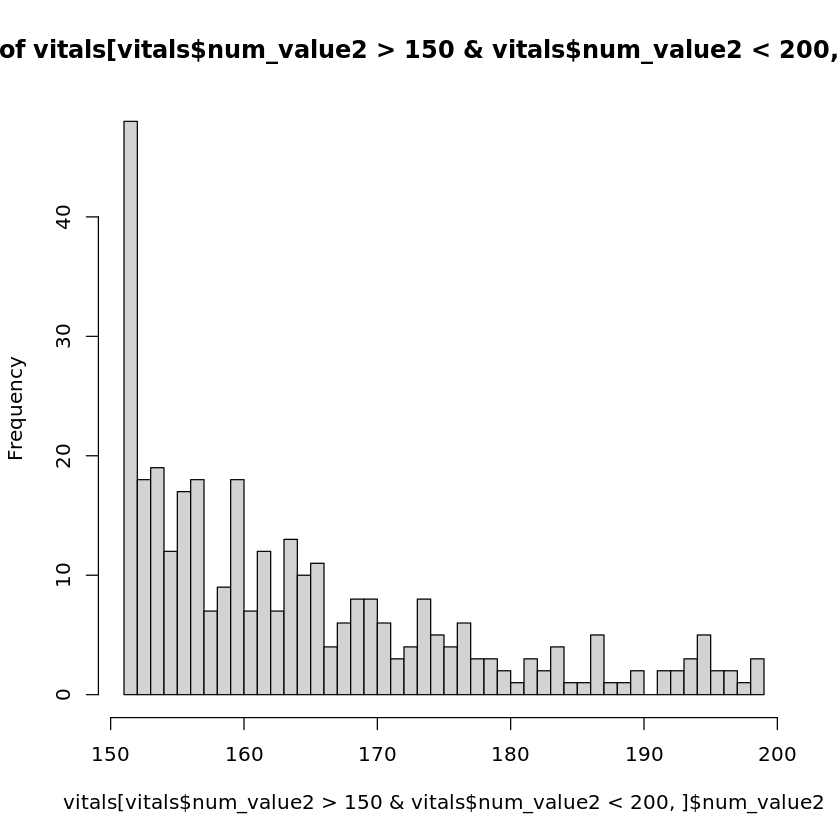

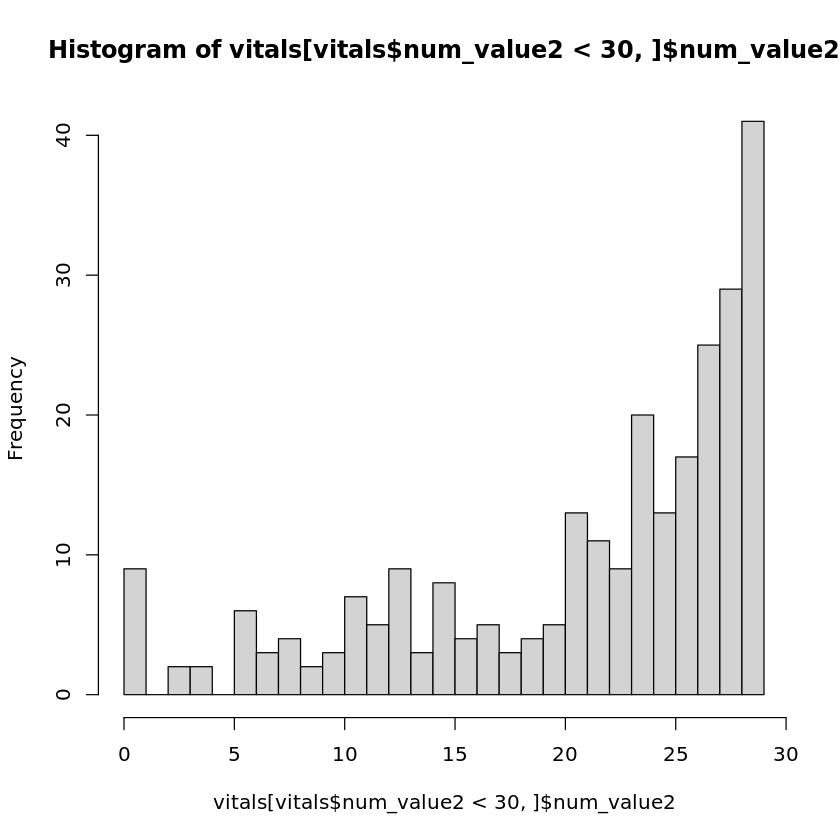

In [15]:
# again, DBP value is num_value2
summary(vitals$num_value2)
nrow(vitals %>% filter(num_value2 > 200))
nrow(vitals %>% filter(num_value2 < 15))

hist(vitals[vitals$num_value2 > 150 & vitals$num_value2 < 200,]$num_value2, breaks =50)
hist(vitals[vitals$num_value2 < 30,]$num_value2, breaks = 30)

### Clean DBP 

[1] 202894

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.00   64.00   75.00   75.75   86.00  238.00 

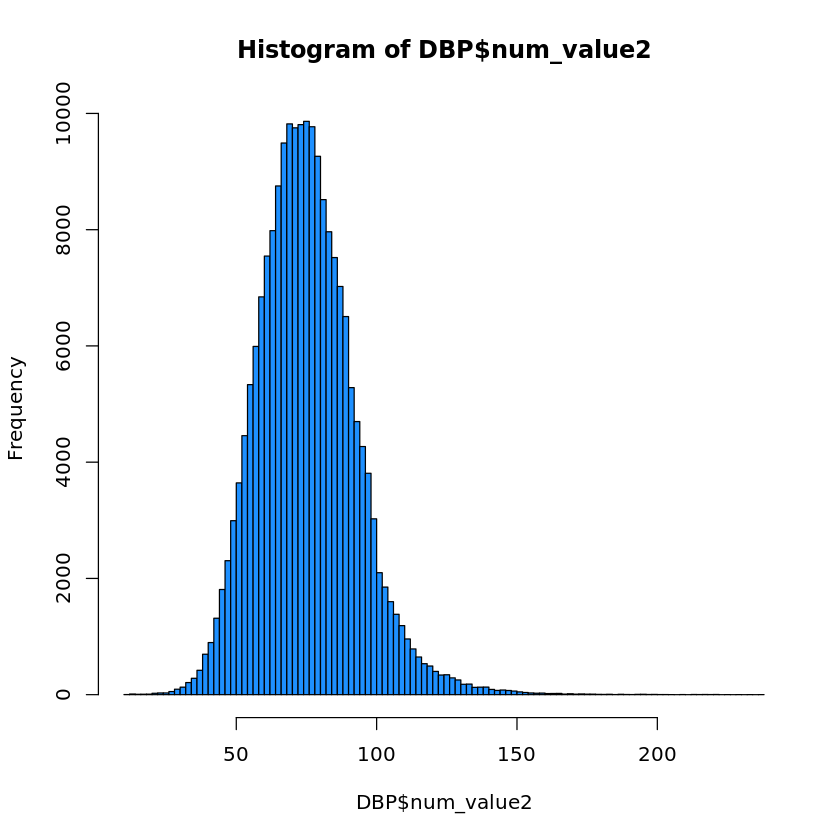

In [17]:
# remove erroneous values for DBP if SBP > 10*DBP, and both SBP and DBP = 0
# will bind rows later --> so ok to filter instead of replacing by NA
DBP <- vitals %>% filter(features == "SBP" & num_value1*num_value2 !=0) %>% 
                    mutate(num_value2 = ifelse(num_value1 > 10*num_value2, NA, num_value2)) %>%
                    drop_na(num_value2) 
nrow(DBP)
summary(DBP$num_value2)
hist(DBP$num_value2, col = "dodgerblue", breaks = 125)

In [18]:
# check DBP and SBP
DBP %>% filter(num_value2 <20) %>% arrange(num_value2)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,num_value1,num_value2,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
JCcc3257,131182220877,19167354,0,2016-03-01 22:35:00+00:00,0,0,0,1,0,⋯,,2016-03-01,,0,0,SBP,2016-02-29 17:06:00+00:00,69,10,1769.00
JCd9dc5f,131251027157,30169334,1,2018-04-16 02:23:00+00:00,1,1,1,1,1,⋯,,2018-04-16,,0,0,SBP,2018-04-16 00:42:00+00:00,94,12,101.00
JCe64650,131115252104,16646852,0,2015-08-15 06:45:00+00:00,0,0,0,1,0,⋯,2019-01-01,2015-08-15,1235 days,0,0,SBP,2015-08-14 21:35:00+00:00,116,13,550.00
JCe64650,131115252104,16646852,0,2015-08-15 06:45:00+00:00,0,0,0,1,0,⋯,2019-01-01,2015-08-15,1235 days,0,0,SBP,2015-08-14 21:30:00+00:00,116,13,555.00
JCe755c5,131248642790,29289155,0,2018-03-11 03:58:00+00:00,0,0,0,1,0,⋯,,2018-03-11,,0,0,SBP,2018-03-10 23:40:00+00:00,71,13,258.00
JCd5f334,131199507206,21510749,1,2016-09-15 11:06:00+00:00,1,1,1,1,1,⋯,2019-01-01,2016-09-15,838 days,0,0,SBP,2016-09-15 08:06:00+00:00,102,13,180.00
JCda2fe2,131259025143,32709155,1,2018-09-27 19:05:00+00:00,1,1,1,1,1,⋯,2019-01-01,2018-09-27,96 days,0,0,SBP,2018-09-27 16:48:00+00:00,35,13,137.00
JCe14e5b,131273610467,39958051,1,2019-09-02 05:49:00+00:00,1,1,1,1,1,⋯,,2019-09-02,,1,0,SBP,2019-09-02 05:15:00+00:00,51,13,34.00
JCe5faab,131272707003,39379259,1,2019-07-27 21:08:00+00:00,1,1,1,1,1,⋯,2020-03-31,2019-07-27,248 days,1,0,SBP,2019-07-27 17:31:00+00:00,64,13,217.00


In [19]:
# change variable name and drop SBP
DBP <- DBP %>% mutate(features = "DBP") %>% 
        select(-c(num_value1, timediff)) %>%
        rename(values = num_value2) %>% distinct()

# remove the one duplicated row
nrow(DBP %>% distinct())
DBP[duplicated(DBP), ]

# rows that are the same except for values, ok to keep
DBP %>% group_by_at(vars(-values)) %>% filter(n() > 1) 

[1] 202893

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,critical_to_acute_label,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,critical_to_acute_label,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>
JCdc571d,131265716149,35550390,1,2019-03-10 10:21:00+00:00,1,0,0,1,1,⋯,1,0,,2019-03-10,,1,0,DBP,2019-03-10 10:00:00+00:00,63
JCdc571d,131265716149,35550390,1,2019-03-10 10:21:00+00:00,1,0,0,1,1,⋯,1,0,,2019-03-10,,1,0,DBP,2019-03-10 10:00:00+00:00,71


In [20]:
# how many GCS score per patient: 35 max
summary(vitals %>% filter(features == "GCS") %>% 
                    group_by(anon_id, pat_enc_csn_id_coded) %>% 
                    count(num_value1) %>% select(num_value1, n))

Adding missing grouping variables: `anon_id`, `pat_enc_csn_id_coded`



   anon_id          pat_enc_csn_id_coded   num_value1          n         
 Length:34717       Min.   :1.311e+11    Min.   : 0.00   Min.   : 1.000  
 Class :character   1st Qu.:1.312e+11    1st Qu.:15.00   1st Qu.: 1.000  
 Mode  :character   Median :1.312e+11    Median :15.00   Median : 1.000  
                    Mean   :1.312e+11    Mean   :14.61   Mean   : 1.279  
                    3rd Qu.:1.313e+11    3rd Qu.:15.00   3rd Qu.: 1.000  
                    Max.   :1.313e+11    Max.   :15.00   Max.   :35.000  
                                         NA's   :130                     

[1] 1074851

[1] "Pulse"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   73.00   87.00   88.84  102.00  300.00     640 
[1] "SpO2"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0      96      98      97      99     100     645 


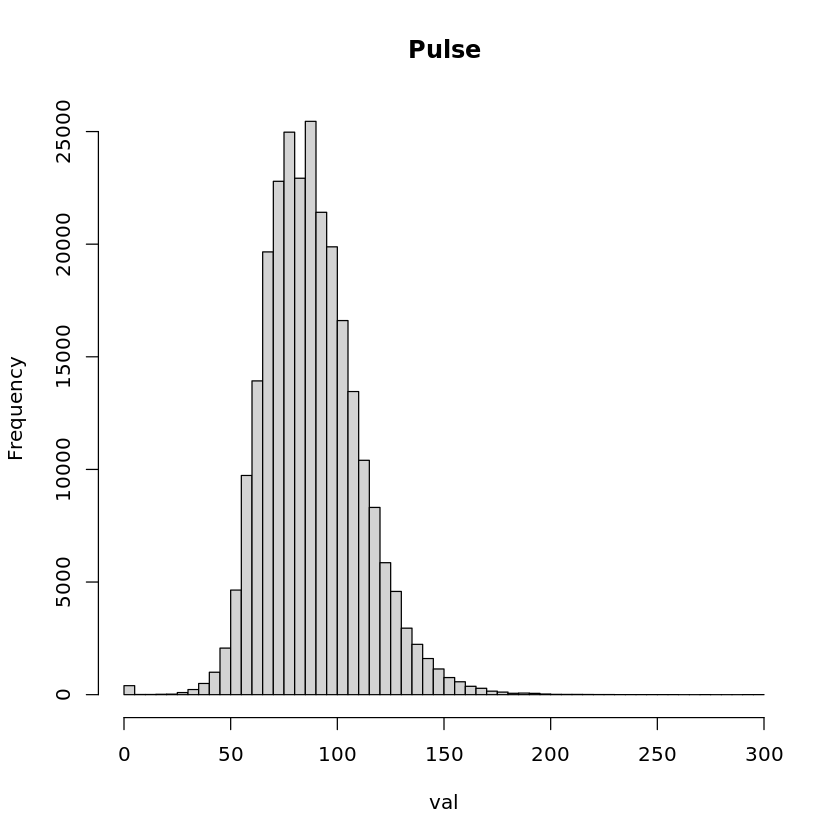

[1] "RR"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0    16.0    18.0    19.2    20.0   189.0     550 


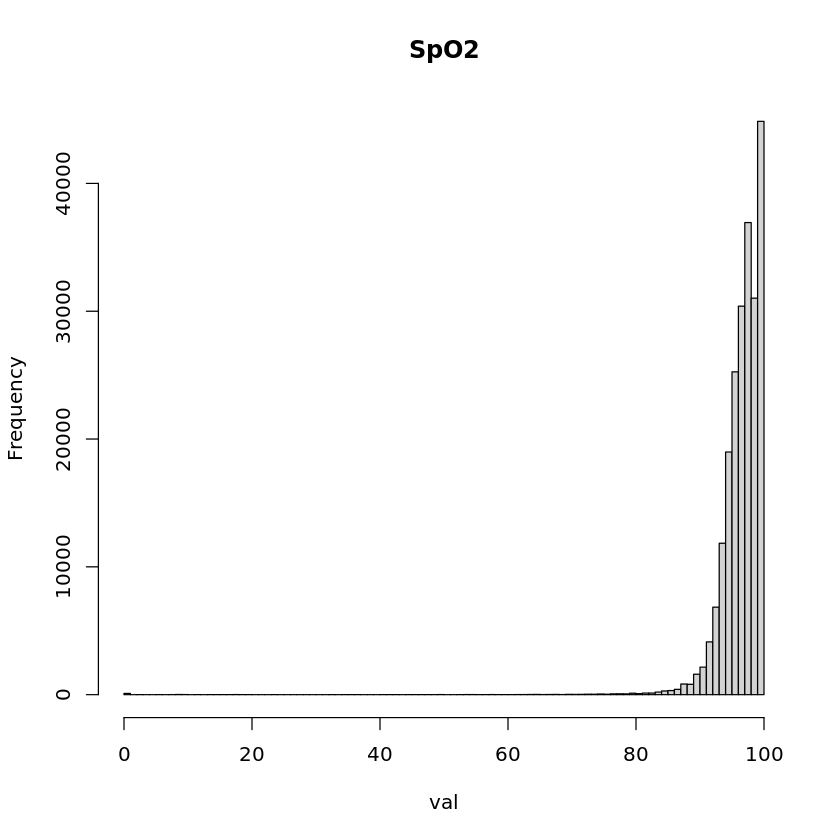

[1] "SBP"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0   111.0   127.0   129.1   145.0   419.0     960 


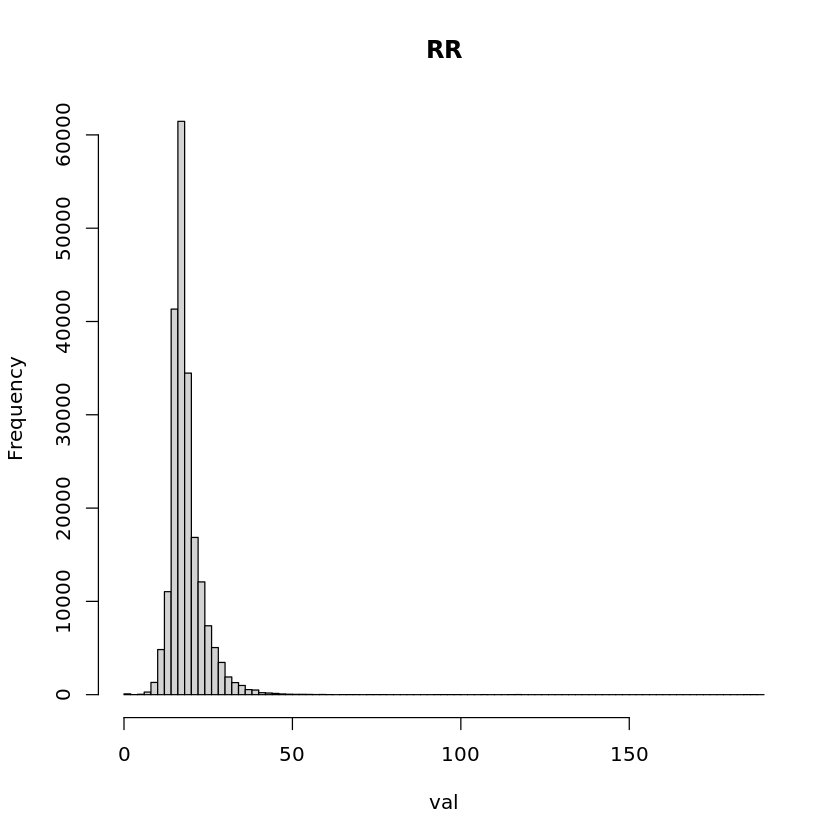

[1] "Temp"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -17.70   36.90   97.50   71.64   98.40  110.20     459 


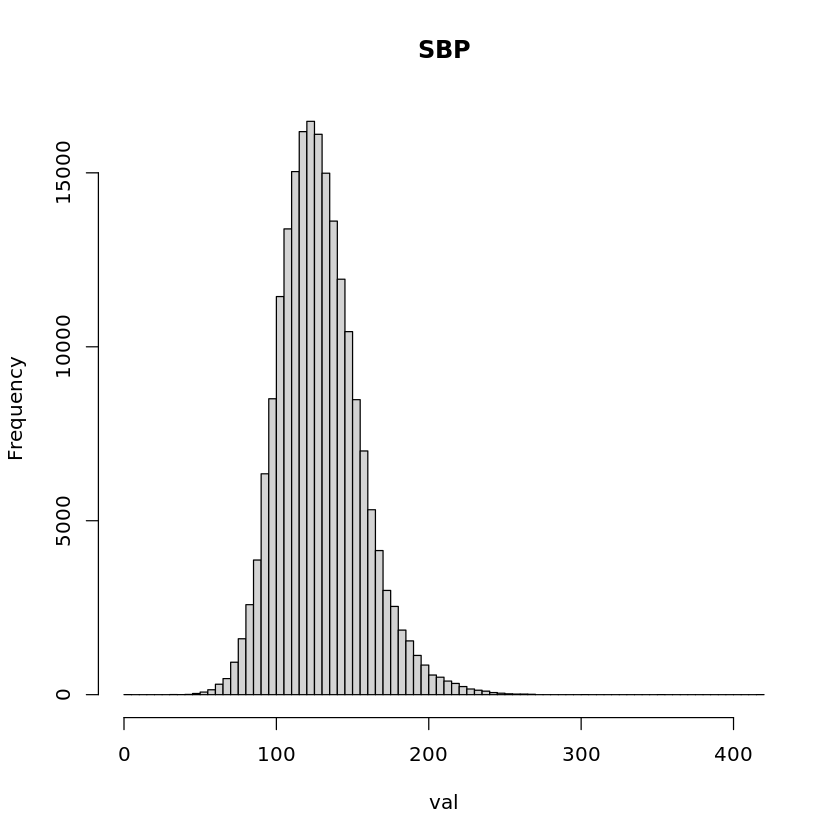

[1] "GCS"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    3.0    15.0    15.0    14.6    15.0    15.0     173 


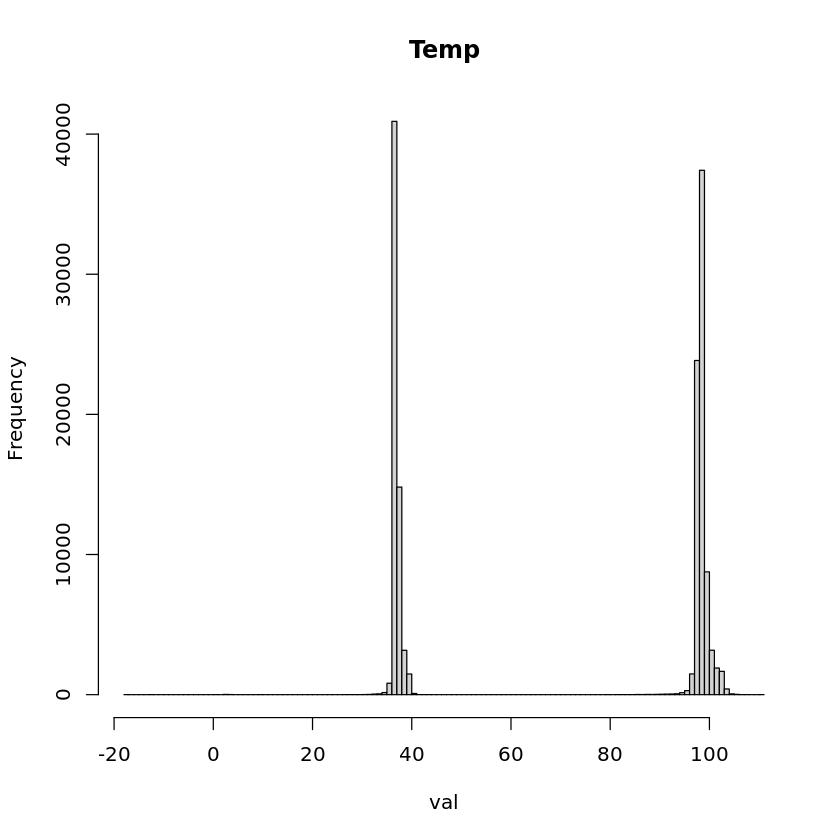

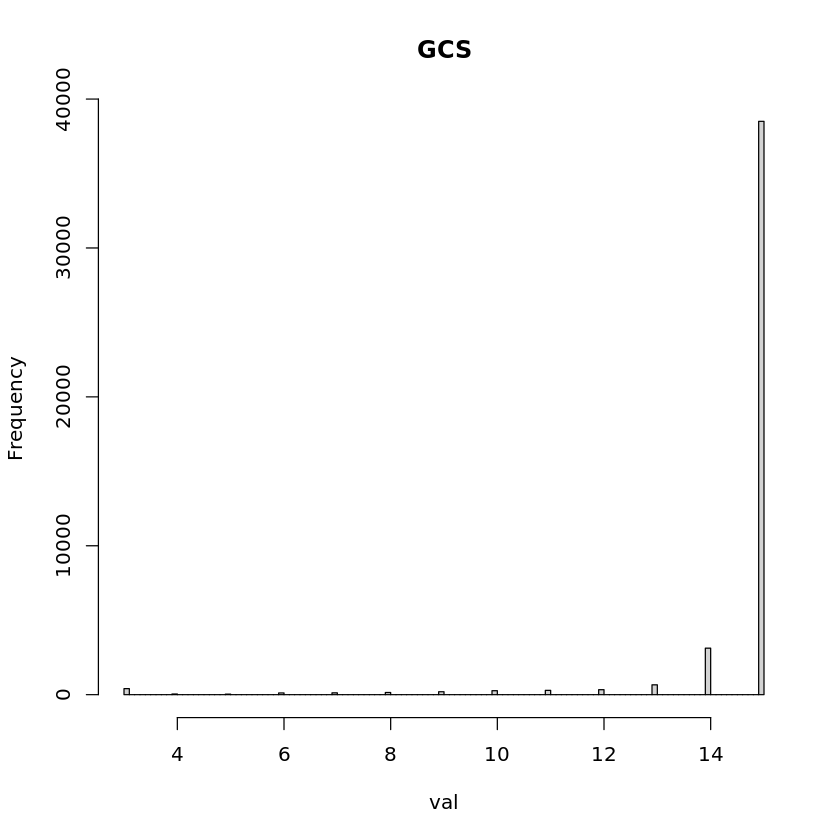

In [21]:
# this set, we look at num_value1 only, no DBP, but first, process GCS: take num_value1 unless:
# GCS num_value1 < 3 (on 0-2 scale), then replaced by num_value2 (only abt 7 patients)
vitals <- vitals %>% mutate(num_value1 = ifelse(features == "GCS",
                                                ifelse(num_value1 >= 3, num_value1, num_value2),
                                                num_value1))
# keep only variable in the list of VS
vitals <- vitals %>% filter(features %in% fs_feats) %>%
                        select(-c(num_value2)) %>% rename(values=num_value1) %>% distinct()

# check for distributions of these
nrow(vitals) # 929382 vs 929186
for (f in fs_feats){
    print(f)
    df = vitals %>% select(features, values) %>%  filter(features==f)
    val = df$values
    print(summary(val))
    hist(val, main = f, breaks = 100)
}

### Explore the rest of VS

[1] 3

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
JC2a1a193,131274427714,40485010,1,2019-08-24 22:09:00+00:00,1,1,1,1,1,⋯,0,,2019-08-24,,1,0,SBP,2019-08-24 20:31:04+00:00,0,97.93333
JCd40aa4,131178765150,18643252,1,2016-02-29 23:05:00+00:00,1,1,1,1,1,⋯,1,2019-01-01,2016-02-29,1037 days,0,0,SBP,2016-02-29 20:45:00+00:00,33,140.00000
JCd40aa4,131178765150,18643252,1,2016-02-29 23:05:00+00:00,1,1,1,1,1,⋯,1,2019-01-01,2016-02-29,1037 days,0,0,SBP,2016-02-29 20:46:51+00:00,33,138.15000
JCda2fe2,131259025143,32709155,1,2018-09-27 19:05:00+00:00,1,1,1,1,1,⋯,1,2019-01-01,2018-09-27,96 days,0,0,SBP,2018-09-27 16:48:00+00:00,35,137.00000
JCe04ae2,131279230382,43521438,1,2019-11-01 03:32:00+00:00,1,1,1,1,1,⋯,0,,2019-11-01,,1,0,SBP,2019-11-01 02:10:00+00:00,37,82.00000
JCe26657,131275652065,41270371,1,2019-08-22 22:40:00+00:00,1,0,0,1,1,⋯,0,,2019-08-22,,1,0,SBP,2019-08-22 21:39:00+00:00,41,61.00000
JCebdb33,131281205434,44717893,1,2019-12-04 06:53:00+00:00,1,1,1,1,1,⋯,0,,2019-12-04,,1,0,SBP,2019-12-04 06:45:00+00:00,41,8.00000
JCe24bea,131272371893,39164758,1,2019-08-07 00:17:00+00:00,NA,0,1,0,1,⋯,0,,2019-08-07,,0,0,SBP,2019-08-06 22:27:00+00:00,44,110.00000
JCd5e08c,131251219481,30241173,1,2018-05-10 00:43:00+00:00,0,1,1,1,0,⋯,0,,2018-05-10,,0,0,SBP,2018-05-09 20:00:00+00:00,45,283.00000


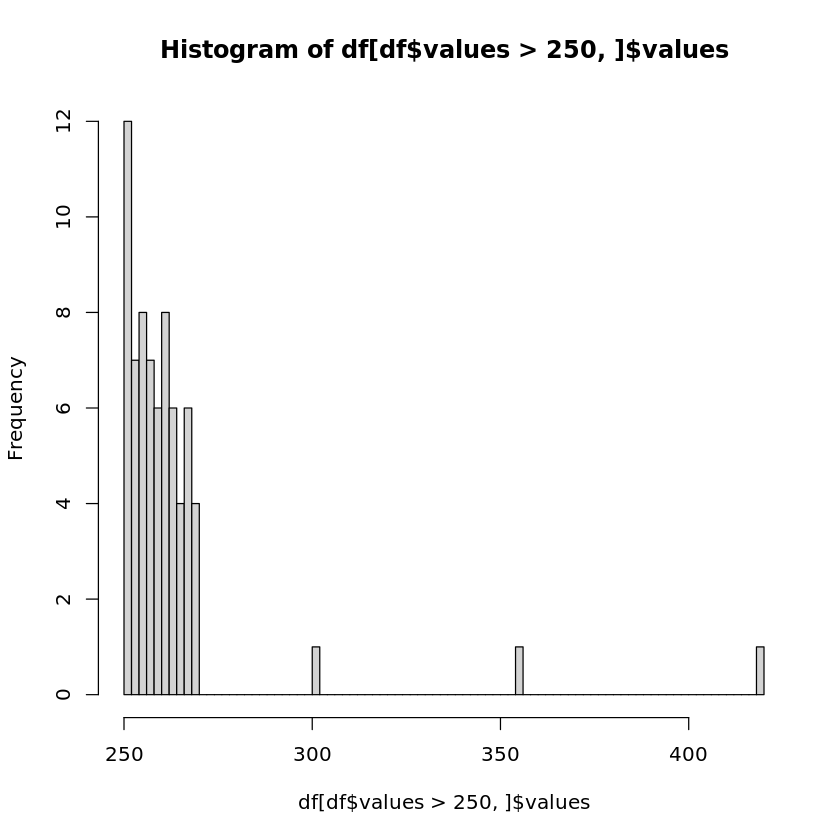

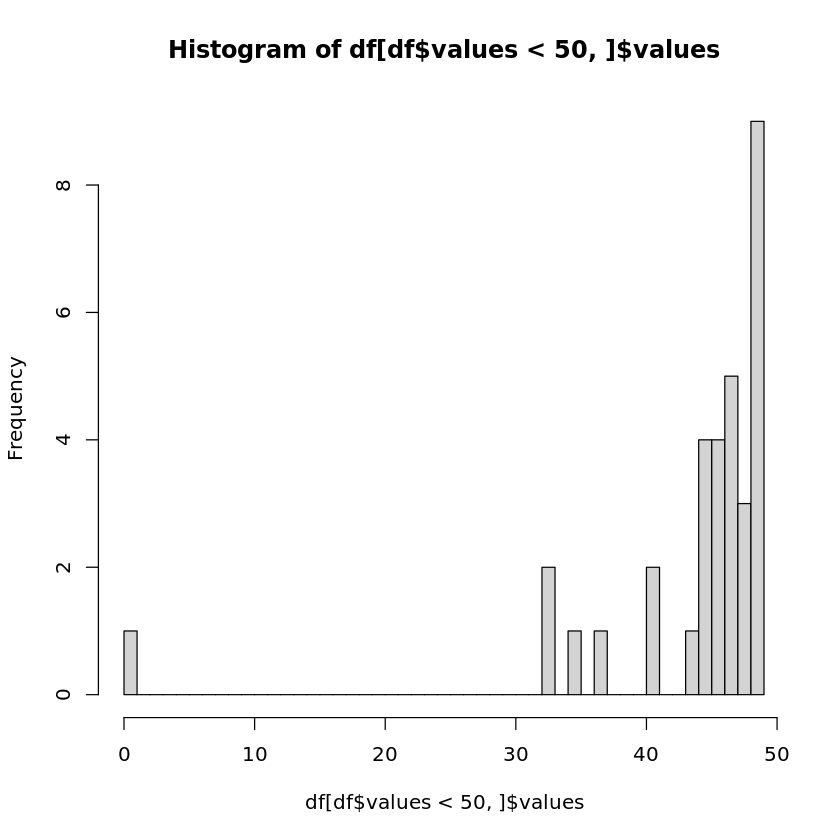

In [22]:
df <- vitals %>% filter(features == "SBP")
nrow(filter(df, values > 310 | values <33))

vitals %>% filter(features == 'SBP' & (values > 300 | values < 50)) %>% arrange(values)

hist(df[df$values > 250,]$values, breaks=100)
hist(df[df$values < 50,]$values, breaks = 50)

[1] 450

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
JCd70f22,131100576218,16135288,0,2015-08-04 15:08:00+00:00,0,0,0,1,0,⋯,1,2019-01-01,2015-08-04,1246 days,0,0,Pulse,2015-08-04 11:48:00+00:00,7,200.00000
JCe21d56,131229395416,24565022,0,2017-05-04 03:13:00+00:00,0,0,0,1,0,⋯,1,2019-01-01,2017-05-04,607 days,0,0,Pulse,2017-05-04 00:43:00+00:00,8,150.00000
JCe125dc,131199958618,21563822,1,2016-10-11 21:27:00+00:00,1,1,1,1,1,⋯,0,,2016-10-11,,0,0,Pulse,2016-10-11 19:16:36+00:00,8,130.40000
JCd21aca,131124315213,16890682,0,2015-09-03 13:30:00+00:00,NA,0,0,0,0,⋯,0,,2015-09-03,,0,0,Pulse,2015-09-03 07:09:00+00:00,9,381.00000
JCd2996a,131241917397,27474181,0,2017-12-26 04:32:00+00:00,0,0,0,1,0,⋯,0,,2017-12-26,,0,0,Pulse,2017-12-26 04:00:00+00:00,9,32.00000
JCe418a5,131194351824,20923027,1,2016-09-10 21:38:00+00:00,NA,1,1,0,1,⋯,1,2019-01-01,2016-09-10,843 days,0,0,Pulse,2016-09-10 21:32:57+00:00,10,5.05000
JCcc8c61,131275282074,41027512,1,2019-09-18 04:39:00+00:00,1,1,1,1,1,⋯,0,,2019-09-18,,1,0,Pulse,2019-09-18 03:55:00+00:00,11,44.00000
JCcd95bc,131229739138,24607815,1,2017-06-03 07:27:00+00:00,1,1,1,1,1,⋯,1,2020-02-06,2017-06-03,978 days,0,0,Pulse,2017-06-03 05:18:00+00:00,11,129.00000
JCd73cf3,131226052178,24265512,1,2017-04-05 05:49:00+00:00,0,1,1,1,0,⋯,0,,2017-04-05,,0,0,Pulse,2017-04-05 05:15:00+00:00,11,34.00000


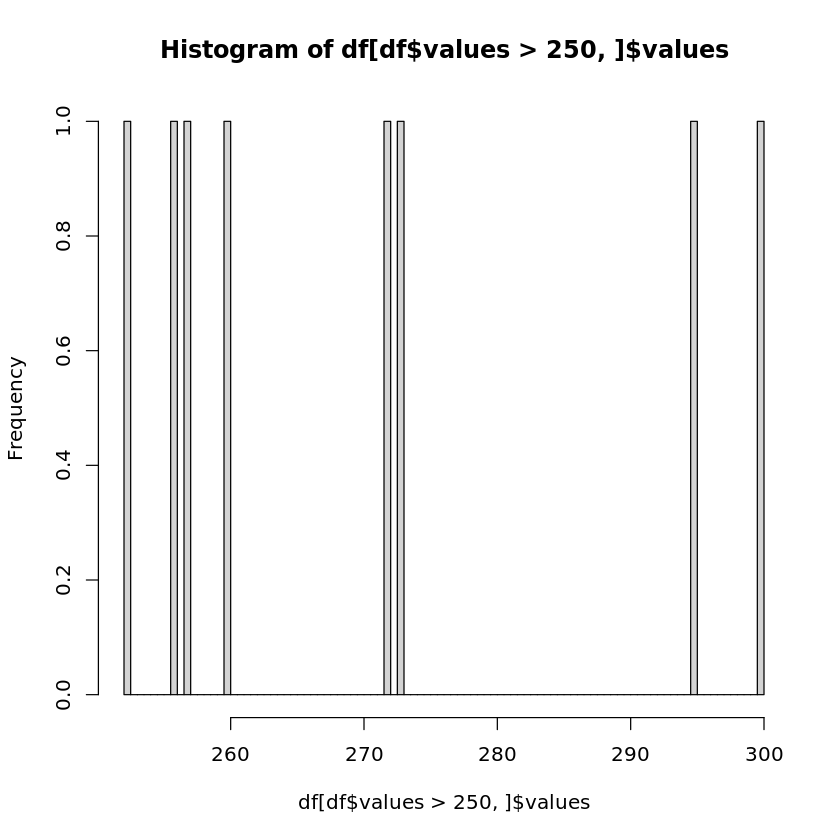

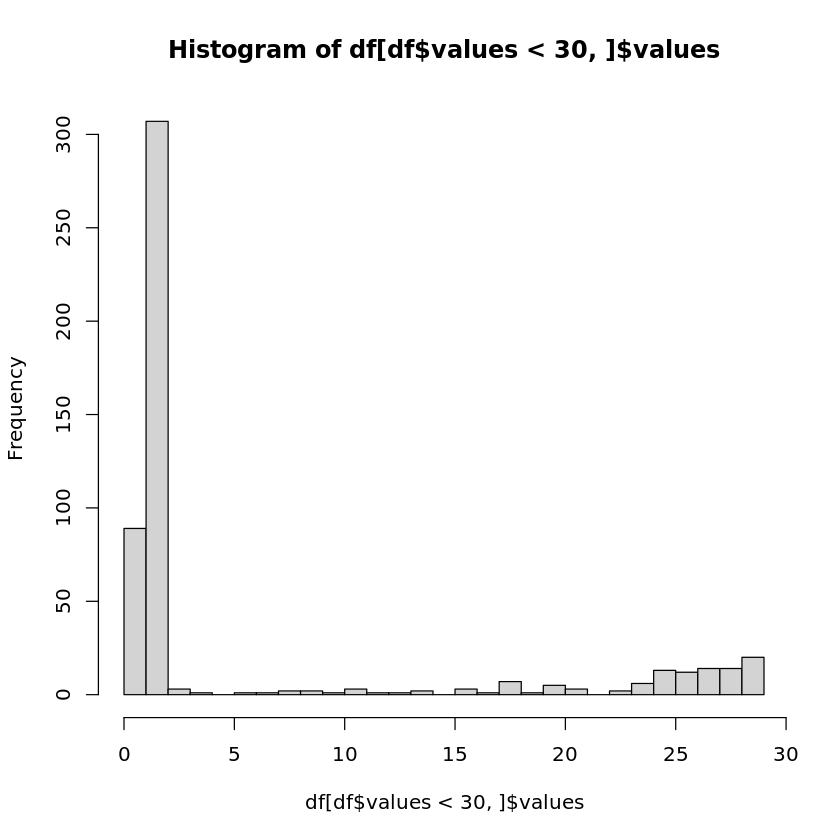

In [23]:
df <- vitals %>% filter(features == "Pulse")
nrow(filter(df, values > 250 | values < 25)) #remove <10 only
filter(df, values > 250 | values < 25 & values > 6) %>% arrange(values)

hist(df[df$values > 250,]$values, breaks=100)
hist(df[df$values < 30,]$values, breaks=25)

[1] 154

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
JCd6e0ff,131259219370,32779469,0,2018-10-28 22:57:00+00:00,0,0,0,1,0,⋯,0,,2018-10-28,,0,0,RR,2018-10-28 19:00:00+00:00,1,237.000000
JCd70f22,131100576218,16135288,0,2015-08-04 15:08:00+00:00,0,0,0,1,0,⋯,1,2019-01-01,2015-08-04,1246 days,0,0,RR,2015-08-04 11:48:00+00:00,1,200.000000
JCd79e25,131272145413,39046522,0,2019-06-26 13:56:00+00:00,0,0,0,1,0,⋯,1,2020-01-07,2019-06-26,195 days,1,0,RR,2019-06-25 04:35:00+00:00,1,2001.000000
JCe417b1,131230525726,24701848,1,2017-05-29 05:16:00+00:00,1,0,1,1,1,⋯,0,,2017-05-29,,0,0,RR,2017-05-29 02:30:00+00:00,1,166.000000
JCe63c45,131274983183,40839473,1,2019-09-26 05:54:00+00:00,1,1,1,1,1,⋯,0,,2019-09-26,,0,0,RR,2019-09-26 05:35:00+00:00,1,19.000000
JCcb95e3,131082830344,15014869,0,2015-04-03 05:48:00+00:00,0,0,0,1,0,⋯,0,,2015-04-03,,0,0,RR,2015-04-02 23:40:00+00:00,2,368.000000
JCd01751,131275616770,41245015,0,2019-08-22 01:41:00+00:00,0,0,0,1,0,⋯,0,,2019-08-22,,1,0,RR,2019-08-22 00:14:00+00:00,2,87.000000
JCd01751,131275616770,41245015,0,2019-08-22 01:41:00+00:00,0,0,0,1,0,⋯,0,,2019-08-22,,1,0,RR,2019-08-22 00:13:00+00:00,2,88.000000
JCd58afe,131258964263,32686475,0,2018-10-18 17:26:00+00:00,0,0,0,1,0,⋯,1,2019-09-07,2018-10-18,324 days,0,0,RR,2018-10-18 14:57:00+00:00,2,149.000000


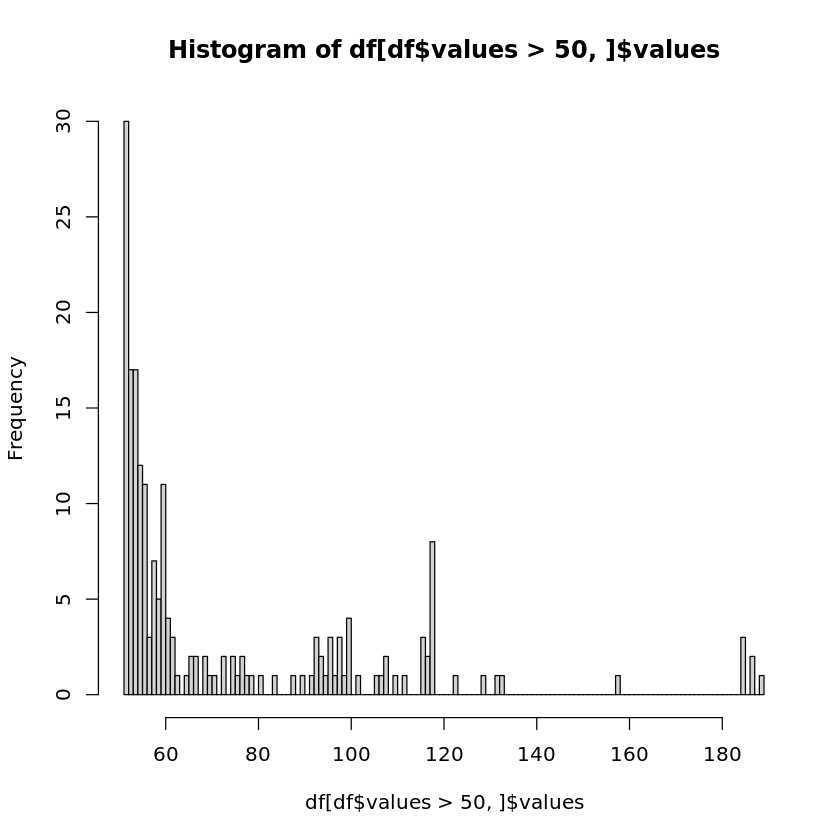

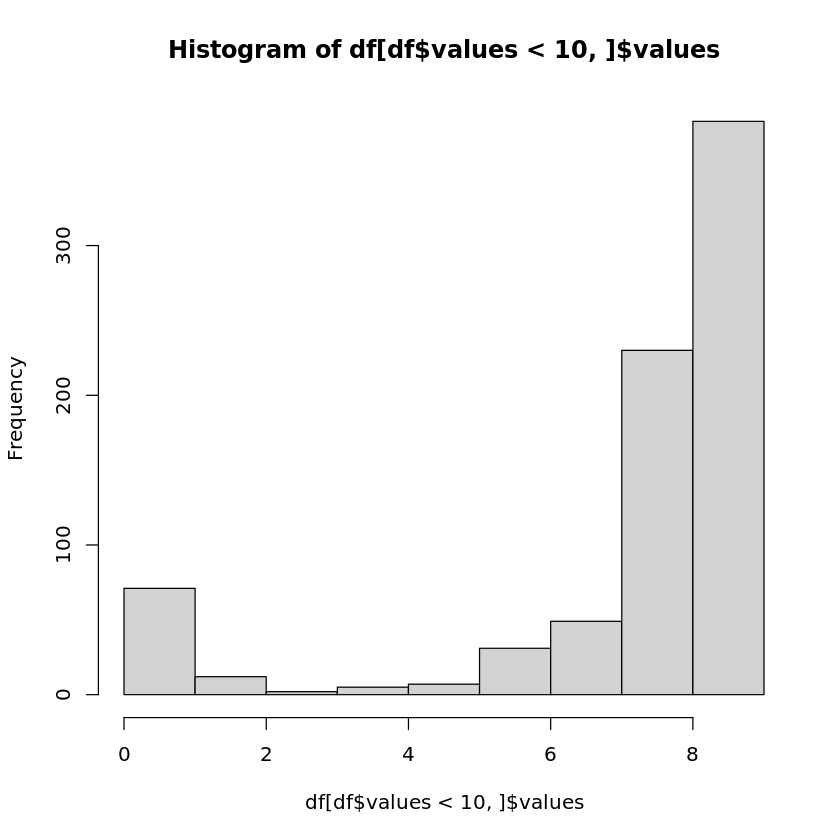

In [24]:
df <- vitals %>% filter(features == "RR")
nrow(filter(df, values > 70 | values < 5))

filter(df, values > 70 | values < 8 & values > 0) %>% arrange(values)

hist(df[df$values > 50,]$values, breaks=100)
hist(df[df$values < 10,]$values, breaks=10)

[1] 157

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
JCe1cb07,131230954606,24757636,1,2017-06-01 00:59:00+00:00,1,1,1,1,1,⋯,0,,2017-06-01,,0,0,SpO2,2017-06-01 00:02:00+00:00,12,57.0000
JCe8b4d7,131107145266,16372528,1,2015-07-19 11:12:00+00:00,1,1,1,1,1,⋯,0,,2015-07-19,,0,0,SpO2,2015-07-19 08:31:00+00:00,12,161.0000
JCe285c1,131250869824,30113465,0,2018-06-07 18:46:00+00:00,0,0,0,1,0,⋯,0,,2018-06-07,,0,0,SpO2,2018-06-07 18:21:00+00:00,14,25.0000
JCe62994,131209217585,22453653,1,2016-12-18 07:39:00+00:00,1,1,1,1,1,⋯,1,2019-01-01,2016-12-18,744 days,0,0,SpO2,2016-12-18 07:00:00+00:00,15,39.0000
JCd907f3,131212613191,22852373,0,2017-01-12 00:13:00+00:00,0,0,0,1,0,⋯,0,,2017-01-12,,0,0,SpO2,2017-01-12 00:00:00+00:00,16,13.0000
JCe1a614,131190953392,20449555,0,2016-08-03 21:47:00+00:00,0,0,0,1,0,⋯,0,,2016-08-03,,0,0,SpO2,2016-08-03 17:30:00+00:00,16,257.0000
JCe7c1dd,131185010921,19592135,1,2016-04-13 23:34:00+00:00,1,0,1,1,1,⋯,0,,2016-04-13,,0,0,SpO2,2016-04-13 22:38:00+00:00,16,56.0000
JCdd5283,131083579576,15099568,0,2015-04-19 19:08:00+00:00,0,0,0,1,0,⋯,1,2019-01-01,2015-04-19,1353 days,0,0,SpO2,2015-04-19 14:13:00+00:00,17,295.0000
JCcb7d65,131066983006,14157131,0,2015-02-19 12:12:00+00:00,0,0,0,1,0,⋯,0,,2015-02-19,,0,0,SpO2,2015-02-19 09:46:00+00:00,18,146.0000


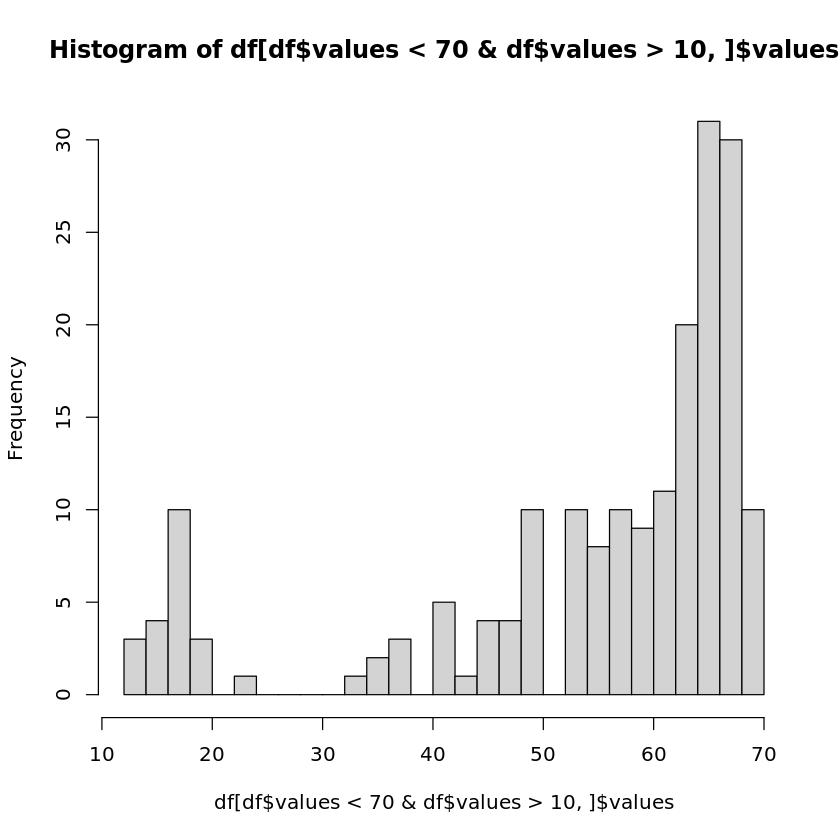

In [25]:
df <- vitals %>% filter(features == "SpO2")
nrow(filter(df, values < 40))
filter(df, values < 50 & values > 10) %>% arrange(values)

hist(df[df$values < 70 & df$values > 10,]$values, breaks=35)

[1] 39

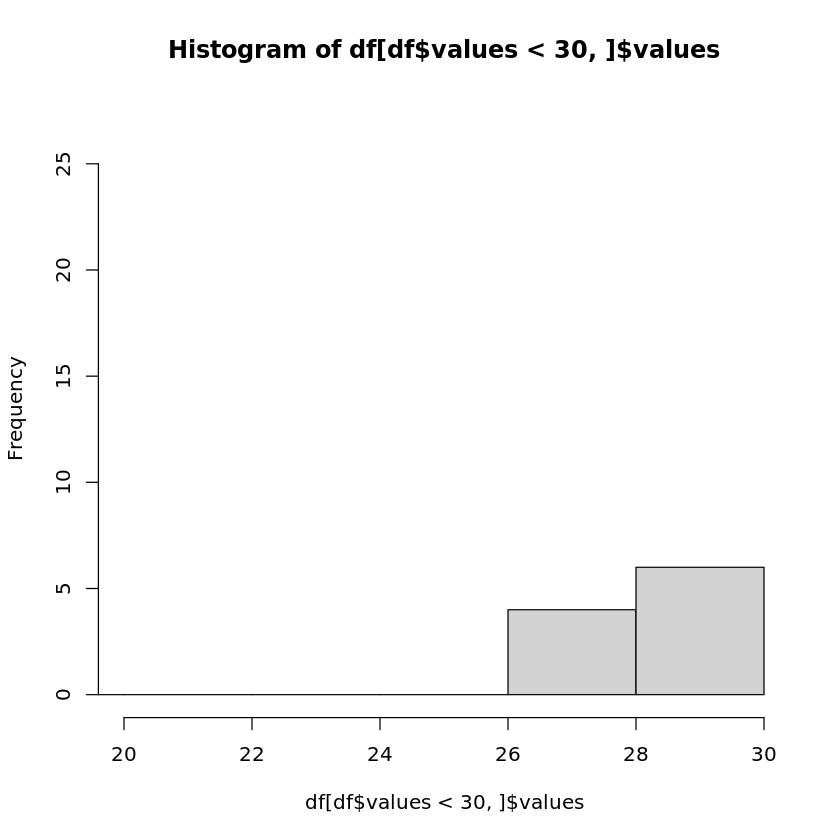

In [26]:
df <-vitals %>% filter(features == "Temp")
nrow(filter(df, values < 30 & values > 0))
hist(df[df$values < 30,]$values, breaks=30, xlim=c(20, 30))

In [27]:
unique(vitals$features)
summary(vitals$values)

head(vitals)

[1] "SBP"   "RR"    "SpO2"  "Temp"  "Pulse" "GCS"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -17.70   36.70   95.00   79.42  100.00  419.00    3427 

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,SBP,2017-06-24 07:21:00+00:00,124,335
2,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,SBP,2017-06-24 12:30:00+00:00,128,26
3,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,SBP,2017-06-24 05:18:00+00:00,141,458
4,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,SBP,2017-06-24 09:00:00+00:00,117,236
5,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,SBP,2017-06-24 10:20:00+00:00,126,156
6,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,RR,2017-06-24 10:20:00+00:00,18,156


### Now clean the variables:
* Note, we did process the GCS first as above: use num_value1, and replace num_value1 < 3 by num_value2
* Then here, we clean temp first as it's a bit more complicated than the rest, but it's only involved num_value1

In [28]:
# process temp: num_value2 is na, for num_value1 <= 60, take it, and for num_value1 > 60, convert to C
# replace num_value1 < 10 (or 20) --> only 2: 0.1 and 9.4 for Temp, and a bunch for Temp(in C)
vitals <- vitals %>% 
            mutate(values=ifelse(features=="Temp",                                  
                                 ifelse(values < 20, NA,
                                         ifelse(values <= 60, values, round((values - 32)*5.0/9.0))),
                                 values))

summary(vitals %>% filter(features == "Temp") %>% select(values))

     values     
 Min.   :26.00  
 1st Qu.:36.70  
 Median :37.00  
 Mean   :36.99  
 3rd Qu.:37.00  
 Max.   :43.40  
 NA's   :490    

In [29]:
# remove  all NA's, by each feature, as the data is in the long format,
# keep only distinct rows, ok with recorded_time same but different values
vitals <- vitals %>% 
            mutate(values = ifelse(features == "SBP" & (values < 33), NA, # < 33 or 30 same effect & > 310 old
                             ifelse(features == "Pulse" & values < 21, NA, # 25 before
                                 ifelse(features == "RR" & (values < 4 | values > 60), NA, # 60 before (tried 70)
                                     ifelse(features == "SpO2" & values < 40, NA, # 40 before (tried 30)
                                         ifelse(features == "Temp" & values < 25, NA, values)))))) %>%  # 29 before, 26 min here
            drop_na(values) %>% distinct()

nrow(vitals)

vitals %>% count(features) %>% arrange(desc(n))
nrow(vitals %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct())
summary(vitals$values)

[1] 1065884

features,n
<chr>,<int>
Pulse,259015
SpO2,217910
RR,205571
SBP,202934
Temp,136209
GCS,44245


[1] 43143

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00   36.30   88.00   75.08  100.00  419.00 

[1] "Pulse"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  21.00   73.00   87.00   88.98  102.00  300.00 
[1] "SpO2"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  41.00   96.00   98.00   97.06   99.00  100.00 


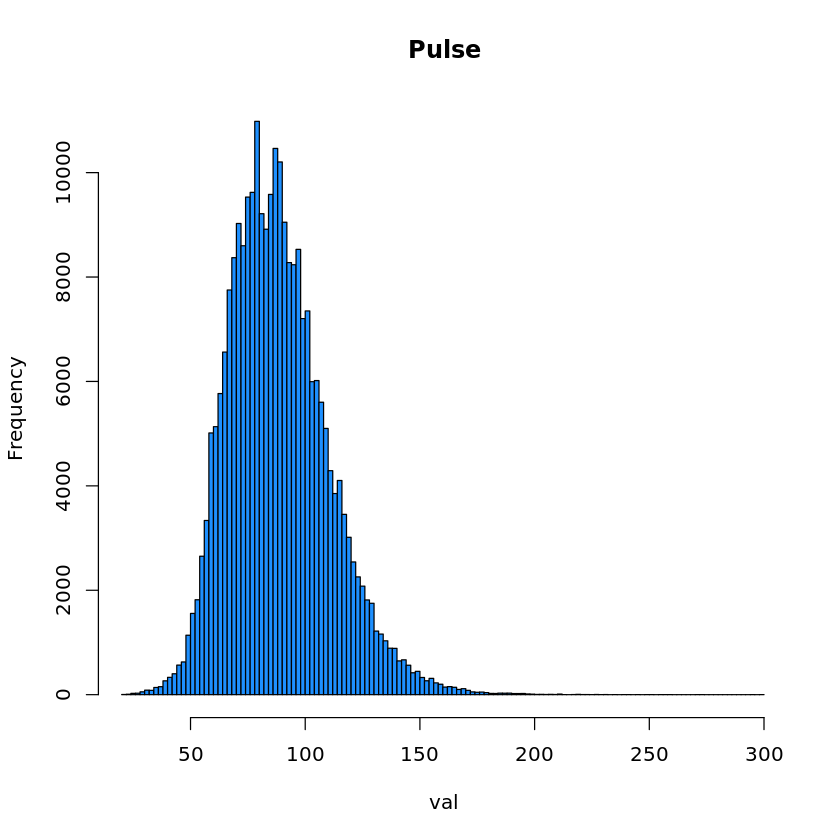

[1] "RR"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4.00   16.00   18.00   19.17   20.00   60.00 


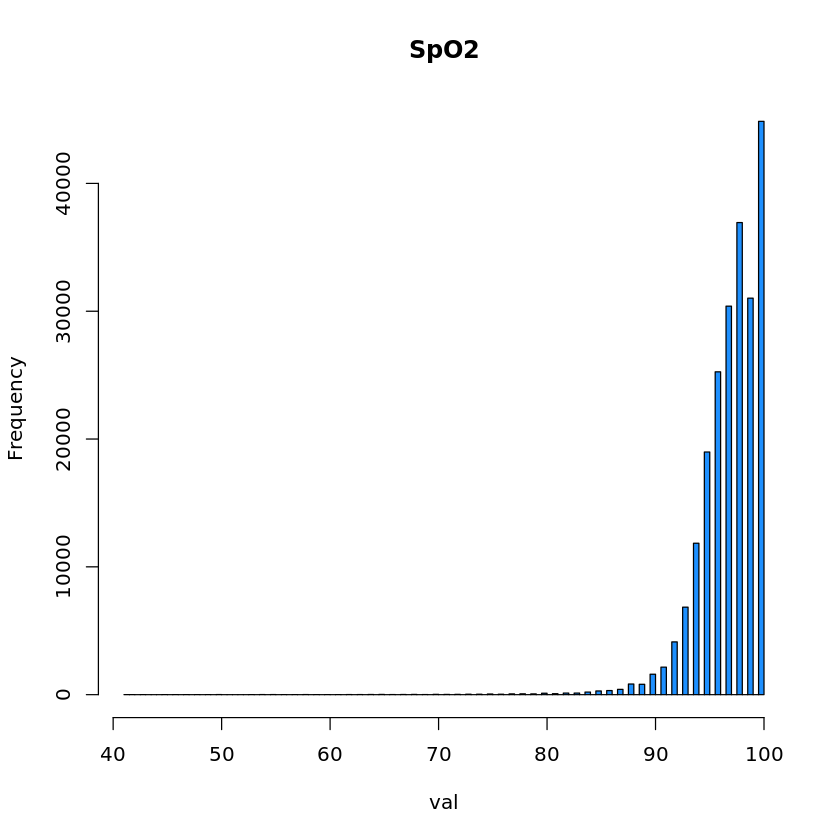

[1] "SBP"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   33.0   111.0   127.0   129.1   145.0   419.0 


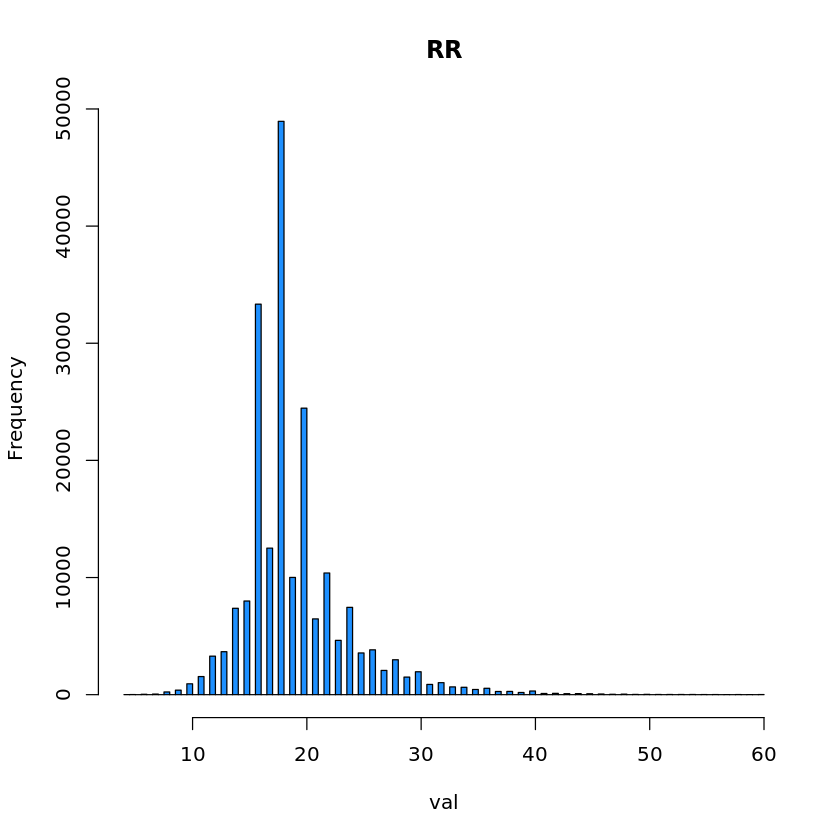

[1] "Temp"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  26.00   36.70   37.00   36.98   37.00   43.40 


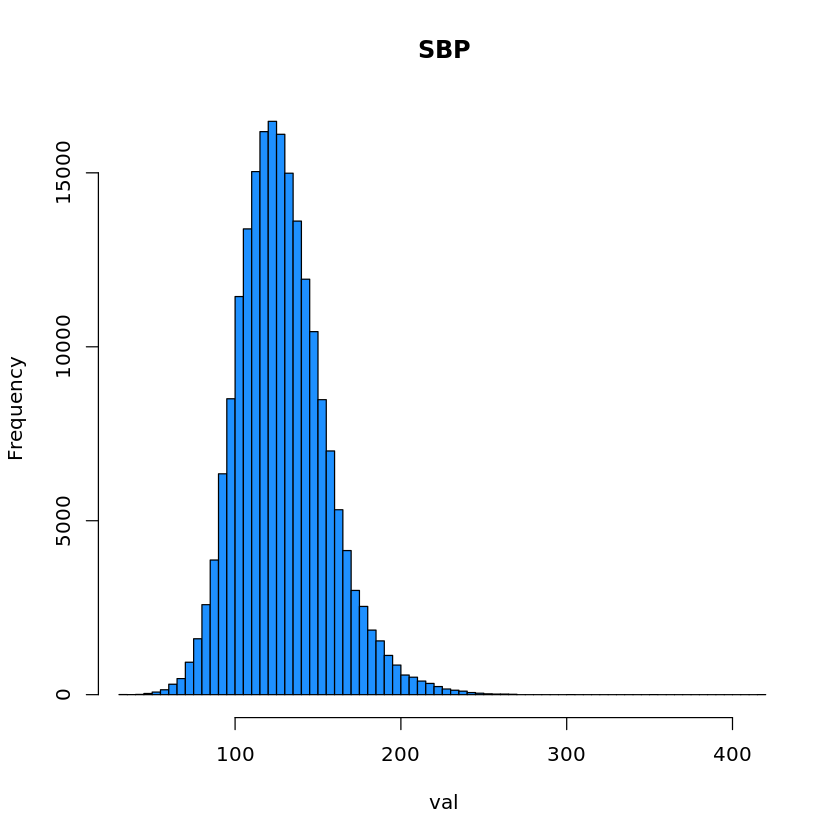

[1] "GCS"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0    15.0    15.0    14.6    15.0    15.0 


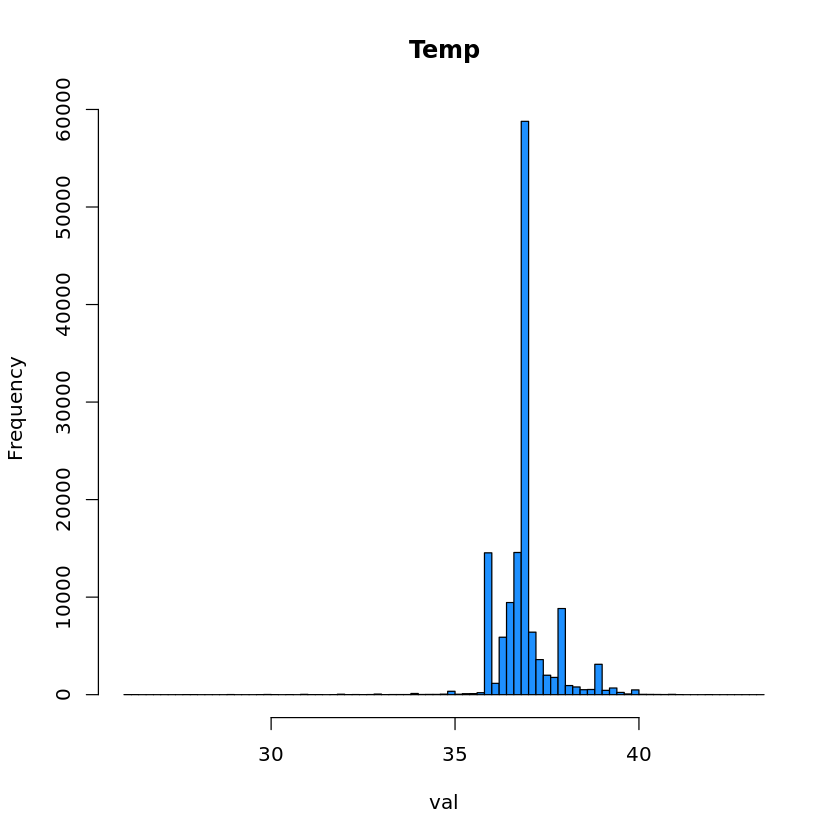

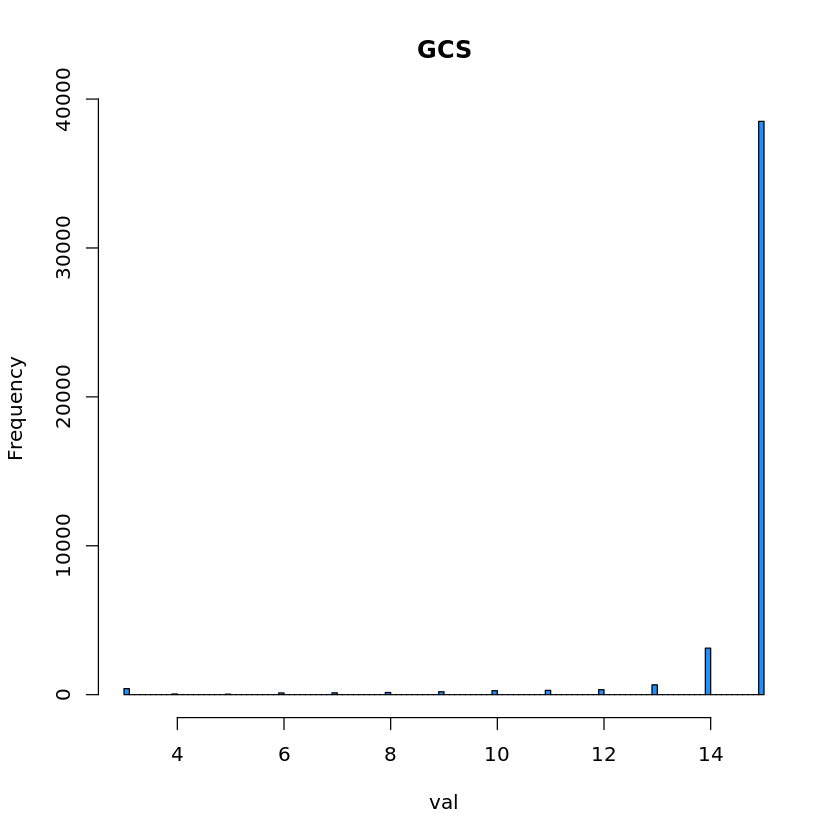

In [30]:
for (f in fs_feats){
    print(f)
    df = vitals %>% select(features, values) %>%  filter(features==f)
    val = df$values
    print(summary(val))
    hist(val, main = f, col="dodgerblue", xlim=c(min(val), max(val)), breaks= 120)
}

In [31]:
# look at duplicates rows with same recorded time, but different values. These are close, ok to keep
for (f in fs_feats){
    print(f)
    df <- vitals %>% filter(features == f) %>% group_by_at(vars(-values)) %>% filter(n() > 1)
    print(nrow(df))
}

[1] "Pulse"
[1] 65739
[1] "SpO2"
[1] 4
[1] "RR"
[1] 4
[1] "SBP"
[1] 4
[1] "Temp"
[1] 113520
[1] "GCS"
[1] 0


In [32]:
vitals %>% filter(features == "SBP") %>% group_by_at(vars(-values)) %>% filter(n() > 1)
vitals %>% filter(features == "SpO2") %>% group_by_at(vars(-values)) %>% filter(n() > 1)
vitals %>% filter(features == "RR") %>% group_by_at(vars(-values)) %>% filter(n() > 1)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
JCe62a6e,131180583645,18920151,0,2016-02-20 12:19:00+00:00,0,0,0,1,0,⋯,0,,2016-02-20,,0,0,SBP,2016-02-20 11:00:00+00:00,100,79
JCe62a6e,131180583645,18920151,0,2016-02-20 12:19:00+00:00,0,0,0,1,0,⋯,0,,2016-02-20,,0,0,SBP,2016-02-20 11:00:00+00:00,117,79
JCdc571d,131265716149,35550390,1,2019-03-10 10:21:00+00:00,1,0,0,1,1,⋯,0,,2019-03-10,,1,0,SBP,2019-03-10 10:00:00+00:00,121,21
JCdc571d,131265716149,35550390,1,2019-03-10 10:21:00+00:00,1,0,0,1,1,⋯,0,,2019-03-10,,1,0,SBP,2019-03-10 10:00:00+00:00,128,21


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
JCe62a6e,131180583645,18920151,0,2016-02-20 12:19:00+00:00,0,0,0,1,0,⋯,0,,2016-02-20,,0,0,SpO2,2016-02-20 11:00:00+00:00,96,79
JCe62a6e,131180583645,18920151,0,2016-02-20 12:19:00+00:00,0,0,0,1,0,⋯,0,,2016-02-20,,0,0,SpO2,2016-02-20 11:00:00+00:00,100,79
JCdc571d,131265716149,35550390,1,2019-03-10 10:21:00+00:00,1,0,0,1,1,⋯,0,,2019-03-10,,1,0,SpO2,2019-03-10 10:00:00+00:00,100,21
JCdc571d,131265716149,35550390,1,2019-03-10 10:21:00+00:00,1,0,0,1,1,⋯,0,,2019-03-10,,1,0,SpO2,2019-03-10 10:00:00+00:00,98,21


anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
JC2a200b4,131277904745,42743953,0,2019-10-20 03:38:00+00:00,0,0,0,1,0,⋯,0,,2019-10-20,,1,0,RR,2019-10-19 23:54:00+00:00,10,224
JC2a200b4,131277904745,42743953,0,2019-10-20 03:38:00+00:00,0,0,0,1,0,⋯,0,,2019-10-20,,1,0,RR,2019-10-19 23:54:00+00:00,14,224
JCdc571d,131265716149,35550390,1,2019-03-10 10:21:00+00:00,1,0,0,1,1,⋯,0,,2019-03-10,,1,0,RR,2019-03-10 10:00:00+00:00,32,21
JCdc571d,131265716149,35550390,1,2019-03-10 10:21:00+00:00,1,0,0,1,1,⋯,0,,2019-03-10,,1,0,RR,2019-03-10 10:00:00+00:00,26,21


In [33]:
df_pulse <- vitals %>% filter(features == "Pulse") %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% 
                arrange(anon_id, pat_enc_csn_id_coded, features, recorded_time, values)
head(df_pulse, n=10)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
JC29f8ad2,131274729058,40679773,0,2019-08-31 12:52:00+00:00,0,0,0,1,0,⋯,0,,2019-08-31,,1,0,Pulse,2019-08-31 12:00:00+00:00,102,52
JC29f8ad2,131274729058,40679773,0,2019-08-31 12:52:00+00:00,0,0,0,1,0,⋯,0,,2019-08-31,,1,0,Pulse,2019-08-31 12:00:00+00:00,106,52
JC29f8bef,131280937356,44544574,0,2019-11-30 10:35:00+00:00,0,0,0,1,0,⋯,0,,2019-11-30,,1,0,Pulse,2019-11-30 09:00:00+00:00,66,95
JC29f8bef,131280937356,44544574,0,2019-11-30 10:35:00+00:00,0,0,0,1,0,⋯,0,,2019-11-30,,1,0,Pulse,2019-11-30 09:00:00+00:00,67,95
JC29f8bef,131280937356,44544574,0,2019-11-30 10:35:00+00:00,0,0,0,1,0,⋯,0,,2019-11-30,,1,0,Pulse,2019-11-30 09:37:00+00:00,63,58
JC29f8bef,131280937356,44544574,0,2019-11-30 10:35:00+00:00,0,0,0,1,0,⋯,0,,2019-11-30,,1,0,Pulse,2019-11-30 09:37:00+00:00,64,58
JC29f8bef,131280937356,44544574,0,2019-11-30 10:35:00+00:00,0,0,0,1,0,⋯,0,,2019-11-30,,1,0,Pulse,2019-11-30 10:00:00+00:00,62,35
JC29f8bef,131280937356,44544574,0,2019-11-30 10:35:00+00:00,0,0,0,1,0,⋯,0,,2019-11-30,,1,0,Pulse,2019-11-30 10:00:00+00:00,63,35
JC29f8c35,131260311400,33171672,0,2018-11-21 11:16:00+00:00,0,0,0,1,0,⋯,0,,2018-11-21,,0,0,Pulse,2018-11-21 06:45:00+00:00,117,271


In [34]:
df_temp <- vitals %>% filter(features == "Temp") %>% group_by_at(vars(-values)) %>% filter(n() > 1) %>% 
                arrange(anon_id, pat_enc_csn_id_coded, features, recorded_time, values)
head(df_temp, n=10)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
JC29f8ad2,131274729058,40679773,0,2019-08-31 12:52:00+00:00,0,0,0,1,0,⋯,0,,2019-08-31,,1,0,Temp,2019-08-31 10:14:00+00:00,36.9,158
JC29f8ad2,131274729058,40679773,0,2019-08-31 12:52:00+00:00,0,0,0,1,0,⋯,0,,2019-08-31,,1,0,Temp,2019-08-31 10:14:00+00:00,37.0,158
JC29f8ad3,131278291027,42992239,0,2019-10-05 23:48:00+00:00,0,0,0,1,0,⋯,0,,2019-10-05,,1,0,Temp,2019-10-05 20:12:00+00:00,36.7,216
JC29f8ad3,131278291027,42992239,0,2019-10-05 23:48:00+00:00,0,0,0,1,0,⋯,0,,2019-10-05,,1,0,Temp,2019-10-05 20:12:00+00:00,37.0,216
JC29f8b9c,131266787806,36261582,0,2019-05-05 01:07:00+00:00,0,0,0,1,0,⋯,0,,2019-05-05,,1,0,Temp,2019-05-05 00:01:00+00:00,39.0,66
JC29f8b9c,131266787806,36261582,0,2019-05-05 01:07:00+00:00,0,0,0,1,0,⋯,0,,2019-05-05,,1,0,Temp,2019-05-05 00:01:00+00:00,39.4,66
JC29f8beb,131264387263,34626013,0,2019-03-15 03:35:00+00:00,0,0,0,1,0,⋯,1,2019-12-22,2019-03-15,282 days,1,0,Temp,2019-03-14 23:58:00+00:00,37.0,217
JC29f8beb,131264387263,34626013,0,2019-03-15 03:35:00+00:00,0,0,0,1,0,⋯,1,2019-12-22,2019-03-15,282 days,1,0,Temp,2019-03-14 23:58:00+00:00,37.1,217
JC29f8beb,131279241689,43527040,0,2019-11-27 15:29:00+00:00,0,0,0,1,0,⋯,1,2019-12-22,2019-11-27,25 days,1,0,Temp,2019-11-27 13:41:00+00:00,37.0,108


### Combined DBP back to VS!

In [35]:
head(DBP, n=1)
head(vitals, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,critical_to_acute_label,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values
,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>
1,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,0,,2017-06-24,,0,0,DBP,2017-06-24 07:21:00+00:00,77


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,timediff
,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,SBP,2017-06-24 07:21:00+00:00,124,335


In [36]:
nrow(DBP)
nrow(vitals)
nrow(cohort) # Tiffany's cohort with labels 43,207

vitals <- vitals %>% select(-timediff)
vitals <- bind_rows(vitals, DBP) %>% mutate(feature_type = "vitals") 
summary(vitals$values)
nrow(vitals)
nrow(vitals %>% select(anon_id, pat_enc_csn_id_coded) %>% distinct()) #43,143

[1] 202893

[1] 1065884

[1] 43207

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00   37.00   82.00   75.18   99.00  419.00 

[1] 1268777

[1] 43143

In [37]:
head(vitals, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,feature_type
,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>
1,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,SBP,2017-06-24 07:21:00+00:00,124,vitals


In [38]:
summary(vitals$values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3.00   37.00   82.00   75.18   99.00  419.00 

In [39]:
# save cohort vital signs after cleaning, no NA's here, has recorded time, used for binning
# 43230 encounters, will remove those without vital signs (except for GCS)
write.csv(vitals, file = "../../../Data/vitals_clean.csv", row.names=FALSE)

### Get the first set of vital signs
Use this to combine with demographic table to impute ESI -- OLD under the *features_demographicR1.ipynb*

In [55]:
vitals <- read.csv("../../../Data/vitals_clean.csv")

In [40]:
# same as above, but takes ~8min to run
vs1st <- vitals %>% mutate(recorded_time = ymd_hms(recorded_time)) %>% 
            group_by(anon_id, pat_enc_csn_id_coded, features) %>%
            top_n(n=-1, recorded_time) %>%
            summarise(first_val = mean(values, na.rm=TRUE)) %>% distinct()

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded'. You can override using the `.groups` argument.



In [41]:
nrow(vs1st)
nrow(vs1st %>% distinct(anon_id, pat_enc_csn_id_coded, features))
nrow(vs1st %>% distinct(anon_id, pat_enc_csn_id_coded)) # 43320
head(vs1st)

[1] 292271

[1] 292271

[1] 43429

anon_id,pat_enc_csn_id_coded,features,first_val
<chr>,<dbl>,<chr>,<dbl>
JC29f8ad2,131274729058,DBP,74.00
JC29f8ad2,131274729058,Pulse,95.00
JC29f8ad2,131274729058,RR,20.00
JC29f8ad2,131274729058,SBP,118.00
JC29f8ad2,131274729058,SpO2,99.00
JC29f8ad2,131274729058,Temp,36.95


In [41]:
write.csv(vs1st, "../../../Data/vs1st.csv", row.names=FALSE)

### Get VS for imputation and summary statistics for simple data/model: 

* Demographic features
* Vital signs (no GCS): first and last values, summary statistics, difference from last - first and max - min
* Cohort with labels from Tiffany's and only contains those with at least a complete set of vital signs

Take vs1st already done (or redo faster with top_n), find most recent values, and summary stats

Note that first and last values at the same time might have more than 1, take the average if this happens

In [42]:
# cohort_labels is Tiffany's final cohort of 43,008 encounters (August 2020) vs 43207 (July 2021)
# will update this to remove patients without a complete set of vital signs
# update vs1st, to redo imputation for ESI --> update features_demos_vitals

# vitals <- read.csv("../../../Data/vitals_clean.csv")
# # cohort <- read.csv("./Data/cohort_labels.csv") # from Tif
# cohort <- read.csv("../../../Data/labels_with_death_delta.csv")
# vs1st <- read.csv("../../../Data/vs1st.csv") # 291538

nrow(vitals)
nrow(cohort)
nrow(vs1st)

[1] 1268777

[1] 43207

[1] 290302

In [43]:
nrow(vs1st %>% drop_na() %>% distinct())
nrow(vs1st %>% drop_na() %>% distinct(pat_enc_csn_id_coded)) #43,143

[1] 290302

[1] 43143

In [44]:
head(vitals, n=1)
head(cohort, n=1)
head(vs1st, n=1)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,feature_type
,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>
1,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,SBP,2017-06-24 07:21:00+00:00,124,vitals


,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs
,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>
1,JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,0,0,0,0,,2017-06-24,,0,0


anon_id,pat_enc_csn_id_coded,features,first_val
<chr>,<dbl>,<chr>,<dbl>
JC29f8ad2,131274729058,DBP,74


In [45]:
# get the most recent value of each feature, top_n(n=1, recorded_time) or slice_max
# top_n(n=-1, recorded_time) for earliest value, slice_min
vs_last <- vitals %>% mutate(recorded_time = ymd_hms(recorded_time)) %>% 
            group_by(anon_id, pat_enc_csn_id_coded, features) %>%
            top_n(n=1, recorded_time) %>%
            summarise(last_val = mean(values, na.rm=TRUE)) %>% distinct()

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded'. You can override using the `.groups` argument.



In [46]:
vs_last %>% filter(pat_enc_csn_id_coded == 131231466934) %>% arrange(features)

anon_id,pat_enc_csn_id_coded,features,last_val
<chr>,<dbl>,<chr>,<dbl>
JCcb658e,131231466934,DBP,75.0
JCcb658e,131231466934,GCS,15.0
JCcb658e,131231466934,Pulse,98.0
JCcb658e,131231466934,RR,16.0
JCcb658e,131231466934,SBP,128.0
JCcb658e,131231466934,SpO2,100.0
JCcb658e,131231466934,Temp,36.8


In [47]:
vitals %>% filter(pat_enc_csn_id_coded == 131231466934) %>% arrange(features, recorded_time)

anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,⋯,died,death_date,admit_date,admit_death_delta,in_test_set,died_within_24hrs,features,recorded_time,values,feature_type
<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>
JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,DBP,2017-06-24 05:18:00+00:00,91.0,vitals
JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,DBP,2017-06-24 07:21:00+00:00,77.0,vitals
JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,DBP,2017-06-24 09:00:00+00:00,87.0,vitals
JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,DBP,2017-06-24 10:20:00+00:00,83.0,vitals
JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,DBP,2017-06-24 12:30:00+00:00,75.0,vitals
JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,GCS,2017-06-24 06:48:00+00:00,15.0,vitals
JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,Pulse,2017-06-24 05:18:00+00:00,104.0,vitals
JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,Pulse,2017-06-24 07:21:00+00:00,106.0,vitals
JCcb658e,131231466934,24822070,0,2017-06-24 12:56:00+00:00,0,0,0,1,0,⋯,0,,2017-06-24,,0,0,Pulse,2017-06-24 09:00:00+00:00,102.0,vitals


In [48]:
nrow(cohort %>% select(pat_enc_csn_id_coded) %>% distinct())

[1] 43207

In [59]:
# exclude GCS from first set of VS and for simple data
cohortID <- cohort %>% select(anon_id, pat_enc_csn_id_coded)
vitals <- vitals %>% select(anon_id, pat_enc_csn_id_coded, features, values) %>% 
            filter(features != "GCS")
vs1st <- vs1st %>% filter(features != "GCS") %>% drop_na()

# for calculating diff later
vs_last <- vs_last %>% filter(features != "GCS") %>%  
            select(anon_id, pat_enc_csn_id_coded, features, last_val) %>% drop_na()

In [67]:
colnames(cohortID)
nrow(cohortID)
colnames(vs1st)
colnames(vs_last)
table(vs1st$features)
table(vs_last$features)
summary(vs1st)
summary(vs_last)

[1] "anon_id"              "pat_enc_csn_id_coded"

[1] 43207

[1] "anon_id"              "pat_enc_csn_id_coded" "features"            
[4] "first_val"

[1] "anon_id"              "pat_enc_csn_id_coded" "features"            
[4] "last_val"


  DBP Pulse    RR   SBP  SpO2  Temp 
42988 43031 42980 42991 42945 42158 


  DBP Pulse    RR   SBP  SpO2  Temp 
42988 43031 42980 42991 42945 42158 

   anon_id          pat_enc_csn_id_coded   features           first_val     
 Length:257093      Min.   :1.311e+11    Length:257093      Min.   :  6.00  
 Class :character   1st Qu.:1.312e+11    Class :character   1st Qu.: 36.90  
 Mode  :character   Median :1.312e+11    Mode  :character   Median : 83.00  
                    Mean   :1.312e+11                       Mean   : 76.31  
                    3rd Qu.:1.313e+11                       3rd Qu.:100.00  
                    Max.   :1.313e+11                       Max.   :419.00  

   anon_id          pat_enc_csn_id_coded   features            last_val     
 Length:257093      Min.   :1.311e+11    Length:257093      Min.   :  5.00  
 Class :character   1st Qu.:1.312e+11    Class :character   1st Qu.: 36.95  
 Mode  :character   Median :1.312e+11    Mode  :character   Median : 79.00  
                    Mean   :1.312e+11                       Mean   : 73.88  
                    3rd Qu.:1.313e+11                       3rd Qu.: 99.00  
                    Max.   :1.313e+11                       Max.   :257.00  

In [62]:
# note: cohort size dropped 41758
# get the the cohort with 1st complete set of VS for ESI imputation
cohort1vs <- left_join(cohortID, vs1st) %>% drop_na() %>% spread(features, first_val) %>% drop_na() 
colnames(cohort1vs)
nrow(cohort1vs %>% distinct(pat_enc_csn_id_coded)) # 40953??? if join with cohort directly 
head(cohort1vs, n=1)

Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] "anon_id"              "pat_enc_csn_id_coded" "DBP"                 
[4] "Pulse"                "RR"                   "SBP"                 
[7] "SpO2"                 "Temp"

[1] 41758

,anon_id,pat_enc_csn_id_coded,DBP,Pulse,RR,SBP,SpO2,Temp
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,74,95,20,118,99,36.95


In [69]:
summary(cohort1vs)

   anon_id          pat_enc_csn_id_coded      DBP             Pulse       
 Length:41758       Min.   :1.311e+11    Min.   : 13.00   Min.   : 21.00  
 Class :character   1st Qu.:1.312e+11    1st Qu.: 67.00   1st Qu.: 77.00  
 Mode  :character   Median :1.312e+11    Median : 78.00   Median : 90.00  
                    Mean   :1.312e+11    Mean   : 78.63   Mean   : 92.21  
                    3rd Qu.:1.313e+11    3rd Qu.: 89.00   3rd Qu.:106.00  
                    Max.   :1.313e+11    Max.   :219.00   Max.   :273.00  
       RR             SBP             SpO2             Temp      
 Min.   : 6.00   Min.   : 37.0   Min.   : 43.00   Min.   :26.15  
 1st Qu.:17.00   1st Qu.:116.0   1st Qu.: 96.00   1st Qu.:36.80  
 Median :18.00   Median :131.0   Median : 98.00   Median :36.90  
 Mean   :19.15   Mean   :132.9   Mean   : 97.14   Mean   :36.93  
 3rd Qu.:20.00   3rd Qu.:148.0   3rd Qu.: 99.00   3rd Qu.:37.05  
 Max.   :60.00   Max.   :419.0   Max.   :100.00   Max.   :42.05  

In [52]:
# use this for imputation of ESI
write.csv(cohort1vs, '../../../Data/vs1st_complete.csv', row.names = FALSE)

In [53]:
head(cohort1vs)

,anon_id,pat_enc_csn_id_coded,DBP,Pulse,RR,SBP,SpO2,Temp
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,74,95,20,118,99,36.95
2,JC29f8ad3,131278291027,59,78,18,90,99,36.85
3,JC29f8b9c,131266787806,66,108,26,165,74,39.20
4,JC29f8beb,131264387263,82,93,16,127,98,37.05
5,JC29f8beb,131279241689,64,118,18,116,99,37.05
6,JC29f8bef,131280937356,61,92,18,111,97,38.85


In [77]:
# check cohortID not in vitals as cohortIDs were derived before getting vitals
nrow(cohortID %>% filter(!anon_id %in% vs1st$anon_id))

[1] 50

In [78]:
# join first, last, and the rest of values for vitals
# note: OLD -- left_join cohortID, will result in NA --> use cohort1vs as this already drop the NA (50 not in vs)
vitals0 <- left_join(cohort1vs, vs1st) %>% left_join(vs_last) %>% left_join(vitals) 
nrow(vitals0)
vitals0 %>% group_by(features) %>% count()
head(vitals0, n=1)

Joining, by = c("anon_id", "pat_enc_csn_id_coded")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "features")

Joining, by = c("anon_id", "pat_enc_csn_id_coded", "features")



[1] 1195146

features,n
<chr>,<int>
DBP,197731
Pulse,251722
RR,200201
SBP,197767
SpO2,212314
Temp,135411


,anon_id,pat_enc_csn_id_coded,DBP,Pulse,RR,SBP,SpO2,Temp,features,first_val,last_val,values
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,74,95,20,118,99,36.95,DBP,74,62,74


In [79]:
head(vitals0)

,anon_id,pat_enc_csn_id_coded,DBP,Pulse,RR,SBP,SpO2,Temp,features,first_val,last_val,values
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,JC29f8ad2,131274729058,74,95,20,118,99,36.95,DBP,74,62,74
2,JC29f8ad2,131274729058,74,95,20,118,99,36.95,DBP,74,62,62
3,JC29f8ad2,131274729058,74,95,20,118,99,36.95,Pulse,95,100,102
4,JC29f8ad2,131274729058,74,95,20,118,99,36.95,Pulse,95,100,95
5,JC29f8ad2,131274729058,74,95,20,118,99,36.95,Pulse,95,100,106
6,JC29f8ad2,131274729058,74,95,20,118,99,36.95,Pulse,95,100,100


In [80]:
# get summary stats, including differences for first and last (0 if 1 value), min and max
# all the NA were actually already dropped, so na.rm here is redundant
vsum <- vitals0 %>% 
            group_by(anon_id, pat_enc_csn_id_coded, features, first_val, last_val) %>%
            summarise(count = n(), meanx = mean(values, na.rm=TRUE), medianx = median(values, na.rm=TRUE), 
                      minx = min(values, na.rm=TRUE), maxx = max(values, na.rm=TRUE), sdx = sd(values, na.rm=TRUE),
                      madx = mad(values, na.rm=TRUE), IQRx = IQR(values, na.rm=TRUE)) %>%
            mutate(mmdiff = round(maxx - minx, 1), fldiff = round(last_val - first_val, 1)) #

`summarise()` has grouped output by 'anon_id', 'pat_enc_csn_id_coded', 'features', 'first_val'. You can override using the `.groups` argument.



In [81]:
head(vsum)

anon_id,pat_enc_csn_id_coded,features,first_val,last_val,count,meanx,medianx,minx,maxx,sdx,madx,IQRx,mmdiff,fldiff
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
JC29f8ad2,131274729058,DBP,74.00,62.00,2,68.00,68.00,62.0,74,8.48528137,8.89560,6.00,12.0,-12
JC29f8ad2,131274729058,Pulse,95.00,100.00,4,100.75,101.00,95.0,106,4.57347424,4.44780,4.25,11.0,5
JC29f8ad2,131274729058,RR,20.00,11.00,2,15.50,15.50,11.0,20,6.36396103,6.67170,4.50,9.0,-9
JC29f8ad2,131274729058,SBP,118.00,124.00,2,121.00,121.00,118.0,124,4.24264069,4.44780,3.00,6.0,6
JC29f8ad2,131274729058,SpO2,99.00,99.00,2,99.00,99.00,99.0,99,0.00000000,0.00000,0.00,0.0,0
JC29f8ad2,131274729058,Temp,36.95,36.95,2,36.95,36.95,36.9,37,0.07071068,0.07413,0.05,0.1,0


In [82]:
nrow(vsum)
head(vsum, n=1)
summary(vsum)
table(vsum$features)

[1] 250548

anon_id,pat_enc_csn_id_coded,features,first_val,last_val,count,meanx,medianx,minx,maxx,sdx,madx,IQRx,mmdiff,fldiff
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
JC29f8ad2,131274729058,DBP,74,62,2,68,68,62,74,8.485281,8.8956,6,12,-12


   anon_id          pat_enc_csn_id_coded   features           first_val     
 Length:250548      Min.   :1.311e+11    Length:250548      Min.   :  6.00  
 Class :character   1st Qu.:1.312e+11    Class :character   1st Qu.: 36.90  
 Mode  :character   Median :1.312e+11    Mode  :character   Median : 83.00  
                    Mean   :1.312e+11                       Mean   : 76.16  
                    3rd Qu.:1.313e+11                       3rd Qu.:100.00  
                    Max.   :1.313e+11                       Max.   :419.00  
                                                                            
    last_val          count            meanx           medianx      
 Min.   :  5.00   Min.   :  1.00   Min.   :  8.00   Min.   :  8.00  
 1st Qu.: 36.95   1st Qu.:  2.00   1st Qu.: 36.90   1st Qu.: 36.95  
 Median : 79.00   Median :  3.00   Median : 80.30   Median : 80.00  
 Mean   : 73.73   Mean   :  4.77   Mean   : 74.65   Mean   : 74.49  
 3rd Qu.: 99.00   3rd Qu.:  6.00   3rd 


  DBP Pulse    RR   SBP  SpO2  Temp 
41758 41758 41758 41758 41758 41758 

In [83]:
# replace na of sdx (due to denominator of n-1) as 0
# wide to long on multiple cols to wide
# remove rows with any na --> only complete cases of 1 set of vital signs
vsum_wide <- vsum %>% mutate(sdx = ifelse(is.na(sdx), 0, sdx)) %>%
                gather(variable, value, first_val:fldiff) %>%
                unite(temp, features, variable) %>%
                spread(temp, value) %>% drop_na()

In [84]:
colnames(vsum_wide)
nrow(vsum_wide)
nrow(vsum_wide %>% select(pat_enc_csn_id_coded) %>% distinct()) 
summary(vsum_wide)

[1] "anon_id"              "pat_enc_csn_id_coded" "DBP_count"           
 [4] "DBP_first_val"        "DBP_fldiff"           "DBP_IQRx"            
 [7] "DBP_last_val"         "DBP_madx"             "DBP_maxx"            
[10] "DBP_meanx"            "DBP_medianx"          "DBP_minx"            
[13] "DBP_mmdiff"           "DBP_sdx"              "Pulse_count"         
[16] "Pulse_first_val"      "Pulse_fldiff"         "Pulse_IQRx"          
[19] "Pulse_last_val"       "Pulse_madx"           "Pulse_maxx"          
[22] "Pulse_meanx"          "Pulse_medianx"        "Pulse_minx"          
[25] "Pulse_mmdiff"         "Pulse_sdx"            "RR_count"            
[28] "RR_first_val"         "RR_fldiff"            "RR_IQRx"             
[31] "RR_last_val"          "RR_madx"              "RR_maxx"             
[34] "RR_meanx"             "RR_medianx"           "RR_minx"             
[37] "RR_mmdiff"            "RR_sdx"               "SBP_count"           
[40] "SBP_first_val"        "SBP_fldiff"           "SBP_IQRx"            
[43] "SBP_last_val"         "SBP_madx"             "SBP_maxx"            
[46] "SBP_meanx"            "SBP_medianx"          "SBP_minx"            
[49] "SBP_mmdiff"           "SBP_sdx"              "SpO2_count"          
[52] "SpO2_first_val"       "SpO2_fldiff"          "SpO2_IQRx"           
[55] "SpO2_last_val"        "SpO2_madx"            "SpO2_maxx"           
[58] "SpO2_meanx"           "SpO2_medianx"         "SpO2_minx"           
[61] "SpO2_mmdiff"          "SpO2_sdx"             "Temp_count"          
[64] "Temp_first_val"       "Temp_fldiff"          "Temp_IQRx"           
[67] "Temp_last_val"        "Temp_madx"            "Temp_maxx"           
[70] "Temp_meanx"           "Temp_medianx"         "Temp_minx"           
[73] "Temp_mmdiff"          "Temp_sdx"

[1] 41758

Adding missing grouping variables: `anon_id`



[1] 41758

   anon_id          pat_enc_csn_id_coded   DBP_count      DBP_first_val   
 Length:41758       Min.   :1.311e+11    Min.   : 1.000   Min.   : 13.00  
 Class :character   1st Qu.:1.312e+11    1st Qu.: 2.000   1st Qu.: 67.00  
 Mode  :character   Median :1.312e+11    Median : 3.000   Median : 78.00  
                    Mean   :1.312e+11    Mean   : 4.735   Mean   : 78.63  
                    3rd Qu.:1.313e+11    3rd Qu.: 6.000   3rd Qu.: 89.00  
                    Max.   :1.313e+11    Max.   :75.000   Max.   :219.00  
   DBP_fldiff          DBP_IQRx        DBP_last_val       DBP_madx     
 Min.   :-146.000   Min.   :  0.000   Min.   : 16.00   Min.   : 0.000  
 1st Qu.: -11.000   1st Qu.:  2.000   1st Qu.: 65.00   1st Qu.: 1.483  
 Median :   0.000   Median :  5.500   Median : 74.00   Median : 4.448  
 Mean   :  -3.603   Mean   :  6.906   Mean   : 75.03   Mean   : 5.959  
 3rd Qu.:   3.000   3rd Qu.: 10.000   3rd Qu.: 85.00   3rd Qu.: 8.896  
 Max.   : 138.000   Max.   :115.750   Max. 

In [87]:
write.csv(vsum_wide, '../../../Data/vitalsum_wide.csv', row.names = FALSE)